# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=1981

# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
      dcor_df : The distance correlation matrix as a pandas DataFrame.

    Returns:
      Histogram plot of the distance corelations between features.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates bins with edges at 0, 0.1, ..., 1
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")


**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage. The implementation used for MissForest uses ExtraTrees instead of Random Forests in accordance with the suggestion from Scikit Learn as present in: https://scikit-learn.org/0.21/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
taiwanese_bankruptcy, taiwanese_variables = load_data_from_ucimlrepo(572)

{'uci_id': 572, 'name': 'Taiwanese Bankruptcy Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction', 'data_url': 'https://archive.ics.uci.edu/static/public/572/data.csv', 'abstract': 'The data were collected from the Taiwan Economic Journal  for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6819, 'num_features': 95, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Bankrupt?'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C5004D', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': Non

In [ ]:
taiwanese_bankruptcy.head()

ROA(C) before interest and depreciation before interest  \
0                                           0.370594         
1                                           0.464291         
2                                           0.426071         
3                                           0.399844         
4                                           0.465022         

   ROA(A) before interest and % after tax  \
0                                0.424389   
1                                0.538214   
2                                0.499019   
3                                0.451265   
4                                0.538432   

   ROA(B) before interest and depreciation after tax  Operating Gross Margin  \
0                                           0.405750                0.601457   
1                                           0.516730                0.610235   
2                                           0.472295                0.601450   
3                                           0.457733                0.583541   
4                                           0.522298                0.598783   

   Realized Sales Gross Margin  Operating Profit Rate  \
0                     0.601457               0.998969   
1                     0.610235               0.998946   
2                     0.601364               0.998857   
3                     0.583541               0.998700   
4                     0.598783               0.998973   

   Pre-tax net Interest Rate  After-tax net Interest Rate  \
0                   0.796887                     0.808809   
1                   0.797380                     0.809301   
2                   0.796403                     0.808388   
3                   0.796967                     0.808966   
4                   0.797366                     0.809304   

   Non-industry income and expenditure/revenue  \
0                                     0.302646   
1                                     0.303556   
2                                     0.302035   
3                                     0.303350   
4                                     0.303475   

   Continuous interest rate (after tax)  ...  Total assets to GNP price  \
0                              0.780985  ...                   0.009219   
1                              0.781506  ...                   0.008323   
2                              0.780284  ...                   0.040003   
3                              0.781241  ...                   0.003252   
4                              0.781550  ...                   0.003878   

   No-credit Interval  Gross Profit to Sales  \
0            0.622879               0.601453   
1            0.623652               0.610237   
2            0.623841               0.601449   
3            0.622929               0.583538   
4            0.623521               0.598782   

   Net Income to Stockholder's Equity  Liability to Equity  \
0                            0.827890             0.290202   
1                            0.839969             0.283846   
2                            0.836774             0.290189   
3                            0.834697             0.281721   
4                            0.839973             0.278514   

   Degree of Financial Leverage (DFL)  \
0                            0.026601   
1                            0.264577   
2                            0.026555   
3                            0.026697   
4                            0.024752   

   Interest Coverage Ratio (Interest expense to EBIT)  Net Income Flag  \
0                                           0.564050                 1   
1                                           0.570175                 1   
2                                           0.563706                 1   
3                                           0.564663                 1   
4                                           0.575617                 1   

   Equity to Liability  Target  
0             0.016469       

In [ ]:
taiwanese_variables

name     role        type  \
0                                           Bankrupt?   Target     Integer   
1   ROA(C) before interest and depreciation before...  Feature  Continuous   
2              ROA(A) before interest and % after tax  Feature  Continuous   
3   ROA(B) before interest and depreciation after tax  Feature  Continuous   
4                              Operating Gross Margin  Feature  Continuous   
..                                                ...      ...         ...   
91                                Liability to Equity  Feature  Continuous   
92                 Degree of Financial Leverage (DFL)  Feature  Continuous   
93  Interest Coverage Ratio (Interest expense to E...  Feature  Continuous   
94                                    Net Income Flag  Feature     Integer   
95                                Equity to Liability  Feature  Continuous   

   demographic description units missing_values  
0         None        None  None             no  
1         None        None  None             no  
2         None        None  None             no  
3         None        None  None             no  
4         None        None  None             no  
..         ...         ...   ...            ...  
91        None        None  None             no  
92        None        None  None             no  
93        None        None  None             no  
94        None        None  None             no  
95        None        None  None             no  

[96 rows x 7 columns]

# **Data summary and quality**

In [ ]:
describe_data(taiwanese_bankruptcy)


Data dimension :
Number of Records :  6819 
Number of Features :  96

Datatype of Features :
float64    93
int64       3
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Duplicated records not identified

Data summary :
       ROA(C) before interest and depreciation before interest  \
count                                        6819.000000         
mean                                            0.505180         
std                                             0.060686         
min                                             0.000000         
25%                                             0.476527         
50%                                             0.502706         
75%                                             0.535563         
max                                             1.000000         

       ROA(A) before interest and % after tax  \
count                             6819.000000   
mean                                 0.

# **Split data in train and test set**

In [ ]:
taiwanese_bankruptcy_train, taiwanese_bankruptcy_test = train_test_split(
    taiwanese_bankruptcy, test_size=0.2, random_state=RANDOM_STATE,
    stratify=taiwanese_bankruptcy["Target"]
)
taiwanese_bankruptcy_train['Target'].value_counts()

Target
0    5279
1     176
Name: count, dtype: int64

# **Correlation**

In [ ]:
taiwanese_bankruptcy_train.dtypes

ROA(C) before interest and depreciation before interest    float64
ROA(A) before interest and % after tax                     float64
ROA(B) before interest and depreciation after tax          float64
Operating Gross Margin                                     float64
Realized Sales Gross Margin                                float64
                                                            ...   
Degree of Financial Leverage (DFL)                         float64
Interest Coverage Ratio (Interest expense to EBIT)         float64
Net Income Flag                                              int64
Equity to Liability                                        float64
Target                                                       int64
Length: 96, dtype: object

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

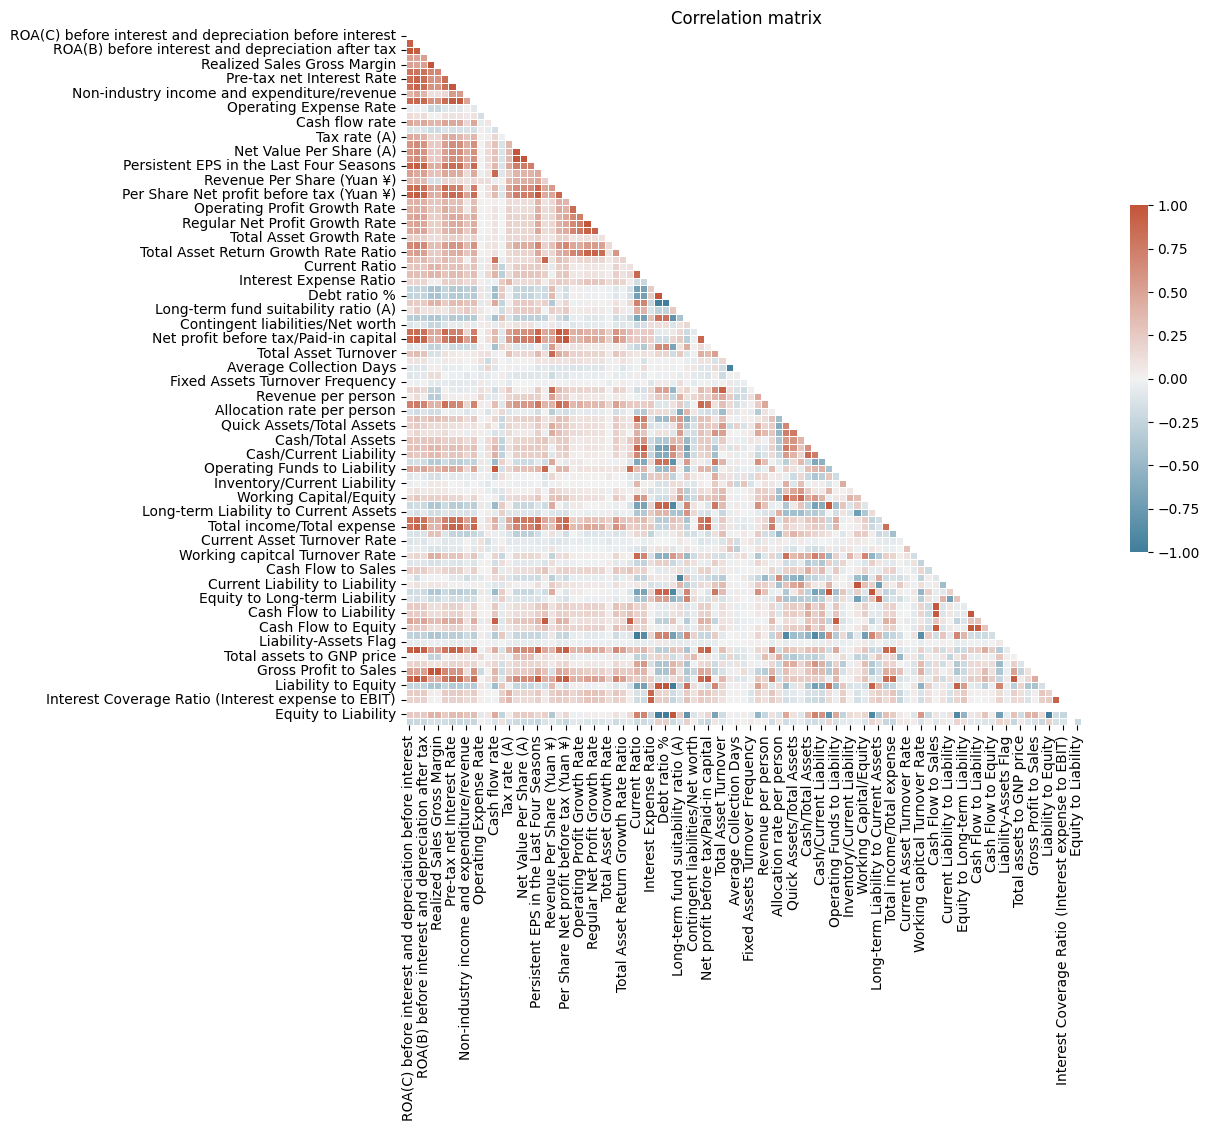

In [ ]:
taiwan_corr = calculate_correlation(taiwanese_bankruptcy_train, 'spearman')

In [ ]:
abs(taiwan_corr['Target']).sort_values(ascending=False)

Target                                      1.000000
Persistent EPS in the Last Four Seasons     0.241323
Net Income to Total Assets                  0.236626
Net profit before tax/Paid-in capital       0.235747
Per Share Net profit before tax (Yuan ¥)    0.235052
                                              ...   
Revenue per person                          0.019559
Inventory Turnover Rate (times)             0.009667
Net Worth Turnover Rate (times)             0.008920
Operating Expense Rate                      0.008045
Net Income Flag                                  NaN
Name: Target, Length: 96, dtype: float64

df columns:  Index(['ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate', 'Cash flow rate',
       'Interest-bearing debt interest rate', 'Tax rate (A)',
       'Net Value Per Share (B)', 'Net Value Per Share (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating Profit Growth Rate', 'After-tax

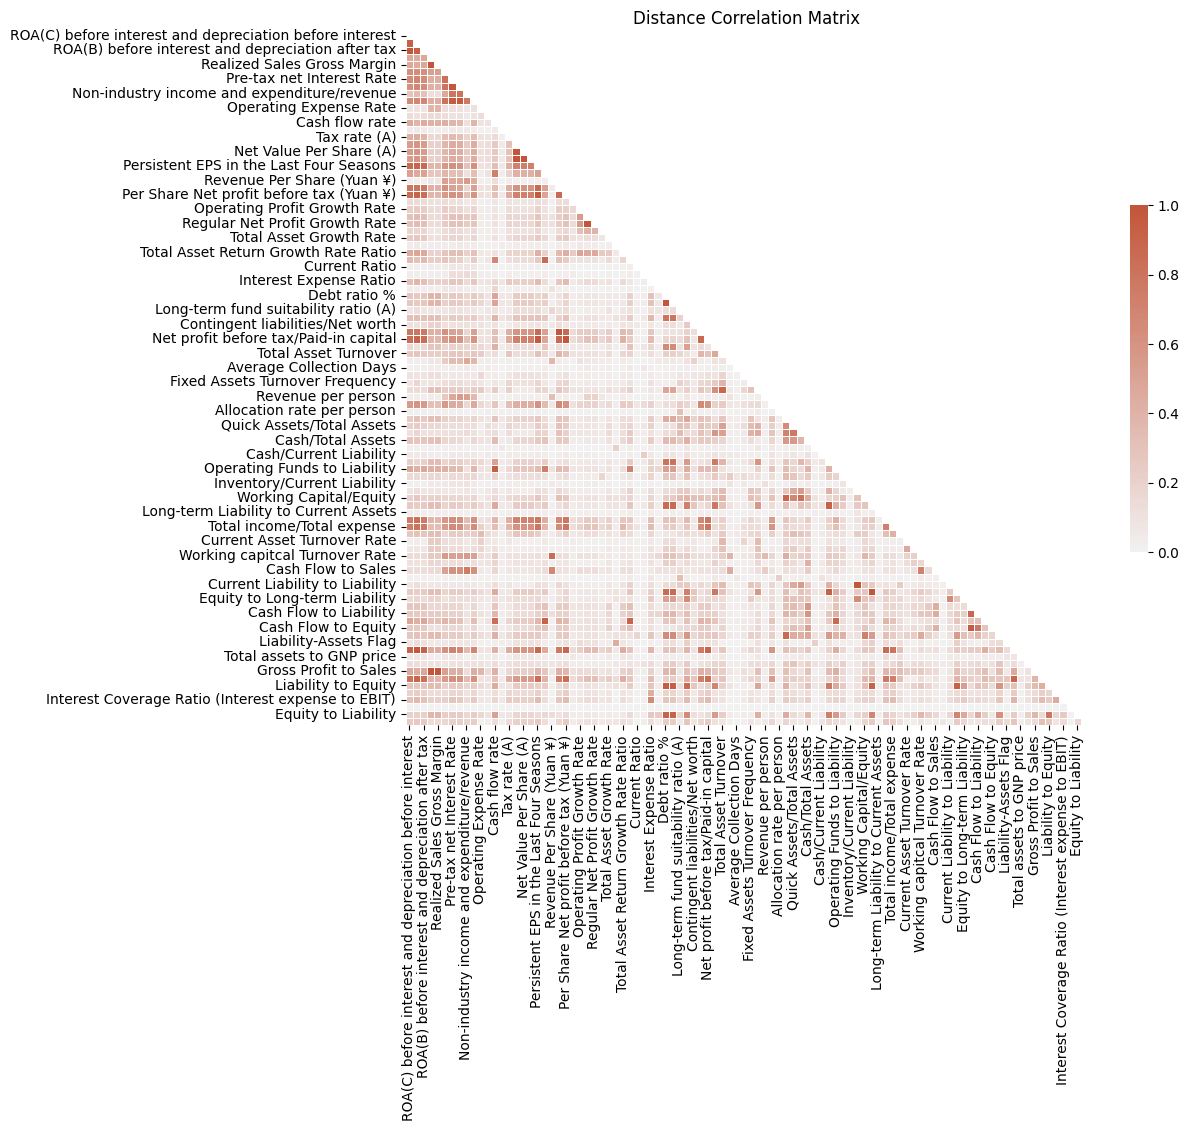

In [ ]:
taiwan_dist_corr = calculate_distance_correlation_matrix(taiwanese_bankruptcy_train)

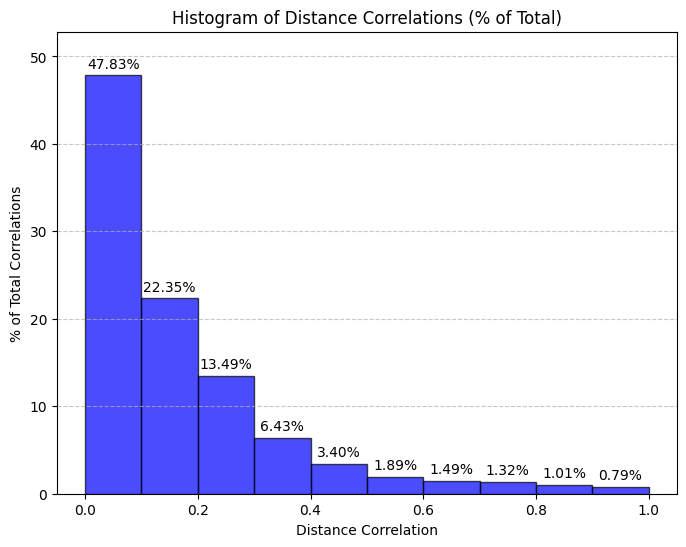

Percentage of correlations below 0.1: 47.83%
Percentage of correlations below 0.2: 70.18%
Percentage of correlations below 0.3: 83.66%
Percentage of correlations below 0.4: 90.09%
Percentage of correlations below 0.5: 93.49%
Percentage of correlations below 0.6: 95.37%
Percentage of correlations below 0.7: 96.86%
Percentage of correlations below 0.8: 98.18%
Percentage of correlations below 0.9: 99.19%
Percentage of correlations below 1.0: 99.98%


In [ ]:
plot_dcor_histogram(taiwan_dist_corr)

# **Pre-feature selection**
Features with zero-variance will be dropped. The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.01

taiwan_zero_variance_columns = identify_zero_variance_columns(taiwanese_bankruptcy_train)

if DROP_WEAK_FEATURES:
  taiwan_weak_features = identify_weak_associated_features(
      taiwan_dist_corr, "Target", WEAK_THRESHOLD
  )
else:
  taiwan_weak_features = []

remove_columns = set(taiwan_zero_variance_columns + taiwan_weak_features)
print(remove_columns)

taiwanese_bankruptcy_train = taiwanese_bankruptcy_train.drop(columns=remove_columns)
taiwanese_bankruptcy_test = taiwanese_bankruptcy_test.drop(columns=remove_columns)

Variance of each column:
ROA(C) before interest and depreciation before interest    0.003679
ROA(A) before interest and % after tax                     0.004294
ROA(B) before interest and depreciation after tax          0.003785
Operating Gross Margin                                     0.000318
Realized Sales Gross Margin                                0.000317
                                                             ...   
Degree of Financial Leverage (DFL)                         0.000244
Interest Coverage Ratio (Interest expense to EBIT)         0.000200
Net Income Flag                                            0.000000
Equity to Liability                                        0.002518
Target                                                     0.031229
Length: 96, dtype: float64
Columns with zero variance to be dropped:
['Net Income Flag']
{'Net Income Flag'}


In [ ]:
print('Original number of features: ', len(taiwanese_bankruptcy.columns))
print('Number of features after pre-feature selection: ', len(taiwanese_bankruptcy_train.columns))

Original number of features:  96
Number of features after pre-feature selection:  95


# **Imbalanced dataset**

In [ ]:
X_train = taiwanese_bankruptcy_train.drop('Target', axis=1)
y_train = taiwanese_bankruptcy_train['Target']

X_test = taiwanese_bankruptcy_test.drop('Target', axis=1)
y_test = taiwanese_bankruptcy_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0      5279    0.967736
1.0       176    0.032264

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
taiwan_imputation_values_dict = calculate_imputation_values_for_missing(taiwanese_bankruptcy_train)
taiwan_imputation_values_dict

{'ROA(C) before interest and depreciation before interest': 0.502656851752547,
 'ROA(A) before interest and % after tax': 0.559692542520715,
 'ROA(B) before interest and depreciation after tax': 0.552063814979389,
 'Operating Gross Margin': 0.606033525994898,
 'Realized Sales Gross Margin': 0.605997492036495,
 'Operating Profit Rate': 0.999022817110695,
 'Pre-tax net Interest Rate': 0.797463472237766,
 'After-tax net Interest Rate': 0.80937493815626,
 'Non-industry income and expenditure/revenue': 0.303525251131211,
 'Continuous interest rate (after tax)': 0.781635097464106,
 'Operating Expense Rate': 0.0002805341342162,
 'Research and development expense rate': 486000000.0,
 'Cash flow rate': 0.465017655989197,
 'Interest-bearing debt interest rate': 0.0003210321032103,
 'Tax rate (A)': 0.0731855450956575,
 'Net Value Per Share (B)': 0.184400151700308,
 'Net Value Per Share (A)': 0.184400151700308,
 'Net Value Per Share (C)': 0.184400151700308,
 'Persistent EPS in the Last Four Season

In [ ]:
taiwan_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
taiwan_cat_vars

['Liability-Assets Flag']

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
    'max_depth': [2],
    'min_samples_split': [0.2],
    'min_samples_leaf': [0.1]
}

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 10:51:49.917866

Nested Cross-validation Results:
Individual scores: [0.32128514 0.31578947 0.29166667]
Average nested CV score: 0.310 (+/- 0.026)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 2, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}

Best Model Performance:
Best CV score: 0.310
2025-01-16 10:51:52.287641

Execution time: 0.04 minutes




```
Starting hyperparameter tuning at: 2025-01-15 13:25:34.126149

Nested Cross-validation Results:
Individual scores: [0.3187251  0.27118644 0.29166667]
Average nested CV score: 0.294 (+/- 0.039)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 2, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}

Best Model Performance:
Best CV score: 0.310

Train score: 0.335
Test score: 0.310
Train-test score difference: 0.025
2025-01-15 13:26:17.282590

Execution time: 0.72 minutes

```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
85  Net Income to Total Assets    0.183567  0.012856
35  Total debt/Total net worth    0.177272  0.006637

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

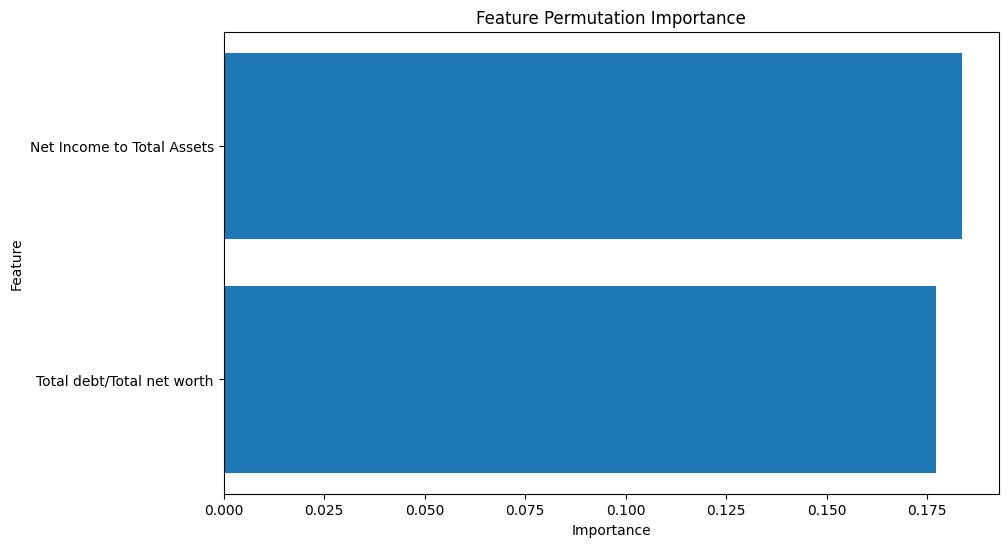

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    taiwan_imputation_values_dict, 20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Net Income to Total Assets
Original feat removed so far:  ['Net Income to Total Assets']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Net Income to Total Assets', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Current Assets/Total Assets
Original feat removed so far:  ['Net Income to Total Assets', 'Total debt/Total net worth', 'Current Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Total income/Total expense
Original feat removed so far:  ['Net Income to Total Assets', 'Total debt/Total net worth', 'Current Assets/Total Assets', 'Total income/Total expense']

--- NEW ITERATION ---
Removing feature:  Current Liabilities/Equity
Original feat removed so far:  ['Net Income to Total Assets', 'Total debt/Total net worth', 'Current Assets/Total Assets', 'Total income/Total expense', 'Current Liabilities/Equity']

--- NEW ITERATION ---
Removing feature: 

In [ ]:
dt_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   31  1194  126  13      19.75   70.45        90.45     89.81     30.85   
1    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
2    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
3    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
4    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
5    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
6    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               80.45                 0   
1               50.00                 1   
2               50.00                 2   
3               50.00                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1              ['Net Income to Total Assets'] imputed  
2   ['Net Income to Total Assets', 'Total debt/Tot...  
3   ['Net Income to Total Assets', 'Total debt/Tot...  
4   ['Net Income to Total Assets', 'Total debt/Tot...  
5   ['Net Income to Total Assets', 'Total debt/Tot...  
6   ['Net Income to Total Assets', 'Total debt/Tot...  
7   ['Net Income to Total Assets', 'Total debt/Tot...  
8   ['Net Income to Total Assets', 'Total debt/Tot...  
9   ['Net Income to Total Assets', 'Total debt/Tot...  
10  ['Net Income to Total Assets', 'Total debt/Tot...  
11  ['Net Income to Total Assets', 'Total debt/Tot...  
12  ['Net Income to Total Assets', 'Total debt/Tot...  
13  ['Net Income to Total Assets', 'Total debt/Tot...  
14  ['Net Income to Total Assets', 'Total debt/Tot...  
15  ['Net Income to Total Assets', 'Total debt/Tot...  
16  ['Net Income to Total Assets', 'Total debt/Tot...  
17  ['Net Income to Total Assets', 'Total debt/Tot...  
18  ['Net Income to Total Assets', 'Total debt/Tot...  
19  ['Net Income to Total Assets', 'Total debt/Tot...  
20  ['Net Income to Total Assets', 'Total debt/Tot...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 10:51:56.440926

--- NEW ITERATION ---
Removing feature:  Net Income to Total Assets
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 

In [ ]:
dt_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   31  1194  126  13      19.75   70.45        90.45     89.81     30.85   
1   31  1202  118  13      20.81   70.45        91.06     90.40     32.12   
2   32  1177  143  12      18.29   72.73        89.17     88.64     29.22   
3   32  1173  147  12      17.88   72.73        88.86     88.34     28.70   
4   32  1173  147  12      17.88   72.73        88.86     88.34     28.70   
5   32  1173  147  12      17.88   72.73        88.86     88.34     28.70   
6   32  1175  145  12      18.08   72.73        89.02     88.49     28.96   
7   32  1175  145  12      18.08   72.73        89.02     88.49     28.96   
8   32  1175  145  12      18.08   72.73        89.02     88.49     28.96   
9   32  1175  145  12      18.08   72.73        89.02     88.49     28.96   
10  32  1176  144  12      18.18   72.73        89.09     88.56     29.09   
11  32  1177  143  12      18.29   72.73        89.17     88.64     29.22   
12  32  1177  143  12      18.29   72.73        89.17     88.64     29.22   
13  32  1177  143  12      18.29   72.73        89.17     88.64     29.22   
14  32  1178  142  12      18.39   72.73        89.24     88.71     29.36   
15  32  1178  142  12      18.39   72.73        89.24     88.71     29.36   
16  31  1179  141  13      18.02   70.45        89.32     88.71     28.70   
17  31  1180  140  13      18.13   70.45        89.39     88.78     28.84   
18  31  1180  140  13      18.13   70.45        89.39     88.78     28.84   
19  31  1182  138  13      18.34   70.45        89.55     88.93     29.11   
20  31  1184  136  13      18.56   70.45        89.70     89.08     29.38   

    balanced_accuracy  num_feat_missing  \
0               80.45                 0   
1               80.76                 1   
2               80.95                 2   
3               80.80                 3   
4               80.80                 4   
5               80.80                 5   
6               80.87                 6   
7               80.87                 7   
8               80.87                 8   
9               80.87                 9   
10              80.91                10   
11              80.95                11   
12              80.95                12   
13              80.95                13   
14              80.98                14   
15              80.98                15   
16              79.89                16   
17              79.92                17   
18              79.92                18   
19              80.00                19   
20              80.08                20   

                                              imputed  
0                                                      
1              ['Net Income to Total Assets'] imputed  
2   ['Net Income to Total Assets', 'Total debt/Tot...  
3   ['Net Income to Total Assets', 'Total debt/Tot...  
4   ['Net Income to Total Assets', 'Total debt/Tot...  
5   ['Net Income to Total Assets', 'Total debt/Tot...  
6   ['Net Income to Total Assets', 'Total debt/Tot...  
7   ['Net Income to Total Assets', 'Total debt/Tot...  
8   ['Net Income to Total Assets', 'Total debt/Tot...  
9   ['Net Income to Total Assets', 'Total debt/Tot...  
10  ['Net Income to Total Assets', 'Total debt/Tot...  
11  ['Net Income to Total Assets', 'Total debt/Tot...  
12  ['Net Income to Total Assets', 'Total debt/Tot...  
13  ['Net Income to Total Assets', 'Total debt/Tot...  
14  ['Net Income to Total Assets', 'Total debt/Tot...  
15  ['Net Income to Total Assets', 'Total debt/Tot...  
16  ['Net Income to Total Assets', 'Total debt/Tot...  
17  ['Net Income to Total Assets', 'Total debt/Tot...  
18  ['Net Income to Total Assets', 'Total debt/Tot...  
19  ['Net Income to Total Assets', 'Total debt/Tot...  
20  ['Net Income to Total Assets', 'Total debt/Tot...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  #best model
  rf_param_grid = {
      'n_estimators': [200],
      'max_features': ['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [0.001],
      'max_depth': [None]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(
    rf_classifier, rf_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:01:45.662222

Nested Cross-validation Results:
Individual scores: [0.46551724 0.40707965 0.48214286]
Average nested CV score: 0.452 (+/- 0.064)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.452
2025-01-16 11:01:59.416883

Execution time: 0.23 minutes




```
Starting hyperparameter tuning at: 2025-01-15 21:43:29.207996

Nested Cross-validation Results:
Individual scores: [0.40837696 0.4260355  0.4519774 ]
Average nested CV score: 0.429 (+/- 0.036)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.452
2025-01-15 23:12:25.689118

Execution time: 88.94 minutes
```



In [ ]:
# rf_grid_search.cv_results_

In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
34                   Interest Expense Ratio    0.011613  0.002811
62              Inventory/Current Liability    0.009578  0.002955
71                Quick Asset Turnover Rate    0.008916  0.001845
58                   Cash/Current Liability    0.006992  0.002558
38     Long-term fund suitability ratio (A)    0.006648  0.001820
..                                      ...         ...       ...
36                             Debt ratio %   -0.037667  0.004038
85               Net Income to Total Assets   -0.042064  0.002909
67        Retained Earnings to Total Assets   -0.047692  0.006000
9      Continuous interest rate (after tax)   -0.052531  0.005678
18  Persistent EPS in the Last Four Seasons   -0.054751  0.003609

[93 rows x 3 columns]

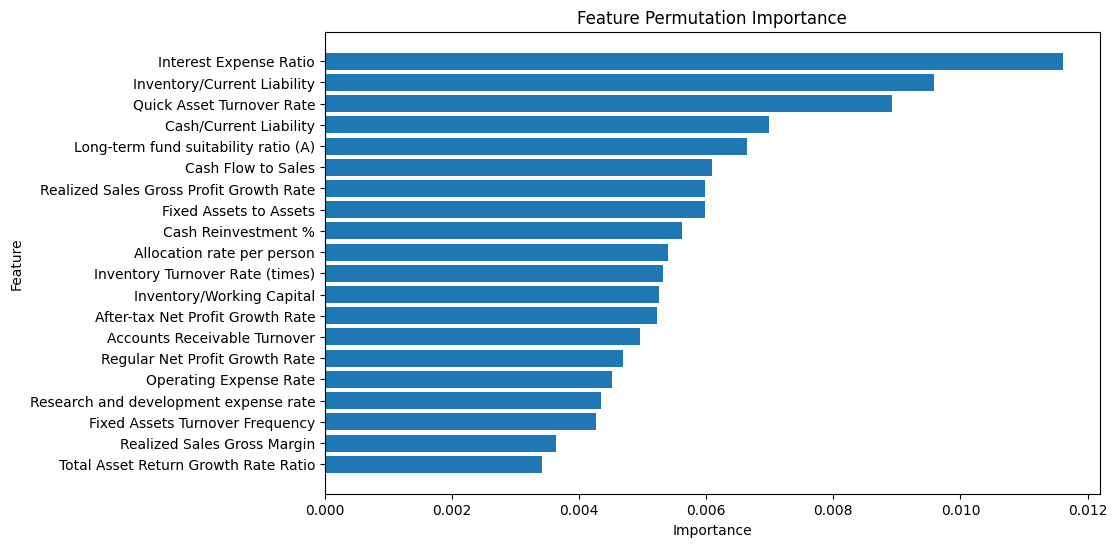

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Interest Expense Ratio']

--- NEW ITERATION ---
Removing feature:  Inventory/Current Liability
Original feat removed so far:  ['Interest Expense Ratio', 'Inventory/Current Liability']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Interest Expense Ratio', 'Inventory/Current Liability', 'Quick Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Interest Expense Ratio', 'Inventory/Current Liability', 'Quick Asset Turnover Rate', 'Cash/Current Liability']

--- NEW ITERATION ---
Removing feature:  Long-term fund suitability ratio (A)
Original feat removed so far:  ['Interest Expense Ratio', 'Inventory/Current Liability', 'Quick Asset Turnover Rate', 'Cash/Current Liability', 'Long-term fund suitability ratio (A)']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Sales

In [ ]:
rf_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   23  1293  27  21      46.00   52.27        97.95     96.48     48.94   
1   23  1294  26  21      46.94   52.27        98.03     96.55     49.46   
2   23  1294  26  21      46.94   52.27        98.03     96.55     49.46   
3   23  1294  26  21      46.94   52.27        98.03     96.55     49.46   
4   23  1294  26  21      46.94   52.27        98.03     96.55     49.46   
5   23  1293  27  21      46.00   52.27        97.95     96.48     48.94   
6   23  1294  26  21      46.94   52.27        98.03     96.55     49.46   
7   23  1294  26  21      46.94   52.27        98.03     96.55     49.46   
8   23  1295  25  21      47.92   52.27        98.11     96.63     50.00   
9   23  1296  24  21      48.94   52.27        98.18     96.70     50.55   
10  23  1296  24  21      48.94   52.27        98.18     96.70     50.55   
11  23  1296  24  21      48.94   52.27        98.18     96.70     50.55   
12  23  1293  27  21      46.00   52.27        97.95     96.48     48.94   
13  23  1294  26  21      46.94   52.27        98.03     96.55     49.46   
14  23  1296  24  21      48.94   52.27        98.18     96.70     50.55   
15  23  1294  26  21      46.94   52.27        98.03     96.55     49.46   
16  24  1293  27  20      47.06   54.55        97.95     96.55     50.53   
17  24  1293  27  20      47.06   54.55        97.95     96.55     50.53   
18  25  1294  26  19      49.02   56.82        98.03     96.70     52.63   
19  25  1294  26  19      49.02   56.82        98.03     96.70     52.63   
20  25  1294  26  19      49.02   56.82        98.03     96.70     52.63   

    balanced_accuracy  num_feat_missing  \
0               75.11                 0   
1               75.15                 1   
2               75.15                 2   
3               75.15                 3   
4               75.15                 4   
5               75.11                 5   
6               75.15                 6   
7               75.15                 7   
8               75.19                 8   
9               75.23                 9   
10              75.23                10   
11              75.23                11   
12              75.11                12   
13              75.15                13   
14              75.23                14   
15              75.15                15   
16              76.25                16   
17              76.25                17   
18              77.42                18   
19              77.42                19   
20              77.42                20   

                                              imputed  
0                                                      
1                  ['Interest Expense Ratio'] imputed  
2   ['Interest Expense Ratio', 'Inventory/Current ...  
3   ['Interest Expense Ratio', 'Inventory/Current ...  
4   ['Interest Expense Ratio', 'Inventory/Current ...  
5   ['Interest Expense Ratio', 'Inventory/Current ...  
6   ['Interest Expense Ratio', 'Inventory/Current ...  
7   ['Interest Expense Ratio', 'Inventory/Current ...  
8   ['Interest Expense Ratio', 'Inventory/Current ...  
9   ['Interest Expense Ratio', 'Inventory/Current ...  
10  ['Interest Expense Ratio', 'Inventory/Current ...  
11  ['Interest Expense Ratio', 'Inventory/Current ...  
12  ['Interest Expense Ratio', 'Inventory/Current ...  
13  ['Interest Expense Ratio', 'Inventory/Current ...  
14  ['Interest Expense Ratio', 'Inventory/Current ...  
15  ['Interest Expense Ratio', 'Inventory/Current ...  
16  ['Interest Expense Ratio', 'Inventory/Current ...  
17  ['Interest Expense Ratio', 'Inventory/Current ...  
18  ['Interest Expense Ratio', 'Inventory/Current ...  
19  ['Interest Expense Ratio', 'Inventory/Current ...  
20  ['Interest Expense Ratio', 'Inventory/Current ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:02:09.443693

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'Aft

In [ ]:
rf_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   23  1293  27  21      46.00   52.27        97.95     96.48     48.94   
1   23  1292  28  21      45.10   52.27        97.88     96.41     48.42   
2   23  1293  27  21      46.00   52.27        97.95     96.48     48.94   
3   23  1293  27  21      46.00   52.27        97.95     96.48     48.94   
4   23  1294  26  21      46.94   52.27        98.03     96.55     49.46   
5   23  1293  27  21      46.00   52.27        97.95     96.48     48.94   
6   22  1294  26  22      45.83   50.00        98.03     96.48     47.83   
7   22  1294  26  22      45.83   50.00        98.03     96.48     47.83   
8   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
9   22  1294  26  22      45.83   50.00        98.03     96.48     47.83   
10  22  1294  26  22      45.83   50.00        98.03     96.48     47.83   
11  22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
12  22  1294  26  22      45.83   50.00        98.03     96.48     47.83   
13  22  1294  26  22      45.83   50.00        98.03     96.48     47.83   
14  22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
15  22  1298  22  22      50.00   50.00        98.33     96.77     50.00   
16  22  1296  24  22      47.83   50.00        98.18     96.63     48.89   
17  21  1297  23  23      47.73   47.73        98.26     96.63     47.73   
18  23  1296  24  21      48.94   52.27        98.18     96.70     50.55   
19  22  1297  23  22      48.89   50.00        98.26     96.70     49.44   
20  22  1296  24  22      47.83   50.00        98.18     96.63     48.89   

    balanced_accuracy  num_feat_missing  \
0               75.11                 0   
1               75.08                 1   
2               75.11                 2   
3               75.11                 3   
4               75.15                 4   
5               75.11                 5   
6               74.02                 6   
7               74.02                 7   
8               74.05                 8   
9               74.02                 9   
10              74.02                10   
11              74.05                11   
12              74.02                12   
13              74.02                13   
14              74.05                14   
15              74.17                15   
16              74.09                16   
17              72.99                17   
18              75.23                18   
19              74.13                19   
20              74.09                20   

                                              imputed  
0                                                      
1                  ['Interest Expense Ratio'] imputed  
2   ['Interest Expense Ratio', 'Inventory/Current ...  
3   ['Interest Expense Ratio', 'Inventory/Current ...  
4   ['Interest Expense Ratio', 'Inventory/Current ...  
5   ['Interest Expense Ratio', 'Inventory/Current ...  
6   ['Interest Expense Ratio', 'Inventory/Current ...  
7   ['Interest Expense Ratio', 'Inventory/Current ...  
8   ['Interest Expense Ratio', 'Inventory/Current ...  
9   ['Interest Expense Ratio', 'Inventory/Current ...  
10  ['Interest Expense Ratio', 'Inventory/Current ...  
11  ['Interest Expense Ratio', 'Inventory/Current ...  
12  ['Interest Expense Ratio', 'Inventory/Current ...  
13  ['Interest Expense Ratio', 'Inventory/Current ...  
14  ['Interest Expense Ratio', 'Inventory/Current ...  
15  ['Interest Expense Ratio', 'Inventory/Current ...  
16  ['Interest Expense Ratio', 'Inventory/Current ...  
17  ['Interest Expense Ratio', 'Inventory/Current ...  
18  ['Interest Expense Ratio', 'Inventory/Current ...  
19  ['Interest Expense Ratio', 'Inventory/Current ...  
20  ['Interest Expense Ratio', 'Inventory/Current ...

##**Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

29.994318181818183

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [25, 15, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
      'n_estimators': [200],
      'max_depth': [4],
      'min_child_samples': [1],
      'min_split_gain': [0.0],
      'reg_lambda': [10.0]
  }

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:11:47.508839

Nested Cross-validation Results:
Individual scores: [0.50909091 0.48148148 0.55652174]
Average nested CV score: 0.516 (+/- 0.062)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 0.0, 'n_estimators': 200, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.516
2025-01-16 11:11:53.621945

Execution time: 0.10 minutes



```
Starting hyperparameter tuning at: 2025-01-13 02:45:25.425769

Nested Cross-validation Results:
Individual scores: [0.48571429 0.46357616 0.49655172]
Average nested CV score: 0.482 (+/- 0.027)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': None, 'min_child_samples': 15, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.502

Train score: 0.989
Test score: 0.502
Train-test score difference: 0.487
2025-01-13 02:54:28.499933

Execution time: 9.05 minutes
---
WITH SCALE_POS_WEIGHT

Starting hyperparameter tuning at: 2025-01-15 13:27:10.165555

Nested Cross-validation Results:
Individual scores: [0.43809524 0.42038217 0.53225806]
Average nested CV score: 0.464 (+/- 0.098)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 0.0, 'n_estimators': 200, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.516

Train score: 0.999
Test score: 0.516
Train-test score difference: 0.483
2025-01-15 13:37:39.697105

Execution time: 10.49 minutes
```



In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
50                       Revenue per person    0.060015  0.009406
13      Interest-bearing debt interest rate    0.050967  0.016882
58                   Cash/Current Liability    0.027317  0.006685
25         After-tax Net Profit Growth Rate    0.018240  0.002287
47          Inventory Turnover Rate (times)    0.016178  0.004100
..                                      ...         ...       ...
35               Total debt/Total net worth   -0.016135  0.004699
18  Persistent EPS in the Last Four Seasons   -0.016795  0.006082
29                    Net Value Growth Rate   -0.017872  0.003722
85               Net Income to Total Assets   -0.018939  0.003937
9      Continuous interest rate (after tax)   -0.019528  0.003663

[86 rows x 3 columns]

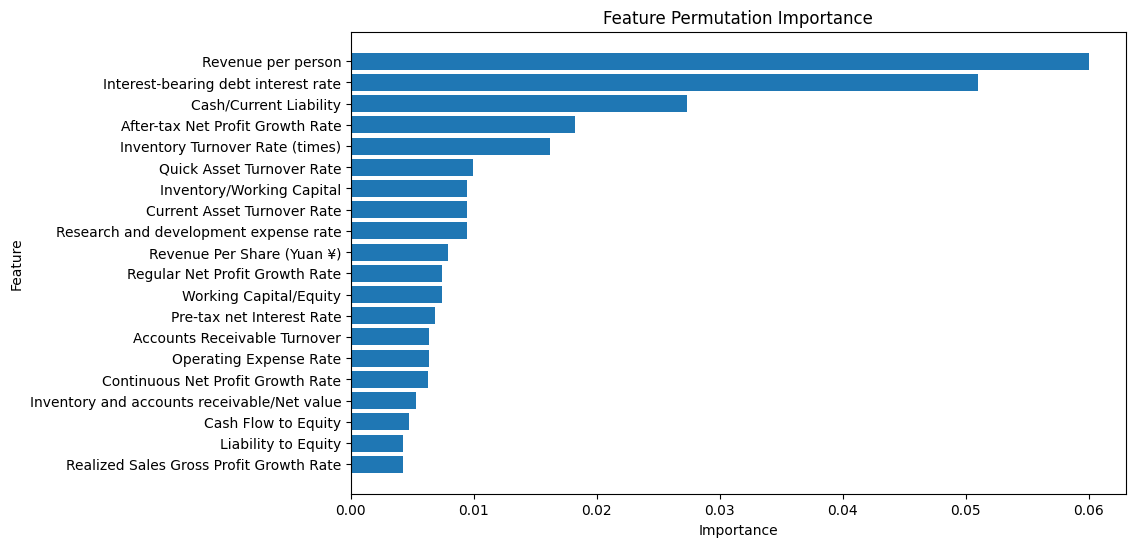

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Revenue per person']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Revenue per person', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Revenue per person', 'Interest-bearing debt interest rate', 'Cash/Current Liability']

--- NEW ITERATION ---
Removing feature:  After-tax Net Profit Growth Rate
Original feat removed so far:  ['Revenue per person', 'Interest-bearing debt interest rate', 'Cash/Current Liability', 'After-tax Net Profit Growth Rate']

--- NEW ITERATION ---
Removing feature:  Inventory Turnover Rate (times)
Original feat removed so far:  ['Revenue per person', 'Interest-bearing debt interest rate', 'Cash/Current Liability', 'After-tax Net Profit Growth Rate', 'Inventory Turnover Rate (times)']

--- NEW ITERATION ---
Removing feat

In [ ]:
gbt_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   17  1303  17  27      50.00   38.64        98.71     96.77     43.59   
1   18  1298  22  26      45.00   40.91        98.33     96.48     42.86   
2   12  1310  10  32      54.55   27.27        99.24     96.92     36.36   
3   14  1305  15  30      48.28   31.82        98.86     96.70     38.36   
4   16  1304  16  28      50.00   36.36        98.79     96.77     42.11   
5   14  1307  13  30      51.85   31.82        99.02     96.85     39.44   
6   16  1305  15  28      51.61   36.36        98.86     96.85     42.67   
7   16  1304  16  28      50.00   36.36        98.79     96.77     42.11   
8   17  1304  16  27      51.52   38.64        98.79     96.85     44.16   
9   16  1303  17  28      48.48   36.36        98.71     96.70     41.56   
10  16  1303  17  28      48.48   36.36        98.71     96.70     41.56   
11  16  1303  17  28      48.48   36.36        98.71     96.70     41.56   
12  16  1302  18  28      47.06   36.36        98.64     96.63     41.03   
13  15  1302  18  29      45.45   34.09        98.64     96.55     38.96   
14  15  1305  15  29      50.00   34.09        98.86     96.77     40.54   
15  15  1301  19  29      44.12   34.09        98.56     96.48     38.46   
16  15  1300  20  29      42.86   34.09        98.48     96.41     37.97   
17  15  1301  19  29      44.12   34.09        98.56     96.48     38.46   
18  15  1303  17  29      46.88   34.09        98.71     96.63     39.47   
19  15  1303  17  29      46.88   34.09        98.71     96.63     39.47   
20  15  1303  17  29      46.88   34.09        98.71     96.63     39.47   

    balanced_accuracy  num_feat_missing  \
0               68.67                 0   
1               69.62                 1   
2               63.26                 2   
3               65.34                 3   
4               67.58                 4   
5               65.42                 5   
6               67.61                 6   
7               67.58                 7   
8               68.71                 8   
9               67.54                 9   
10              67.54                10   
11              67.54                11   
12              67.50                12   
13              66.36                13   
14              66.48                14   
15              66.33                15   
16              66.29                16   
17              66.33                17   
18              66.40                18   
19              66.40                19   
20              66.40                20   

                                              imputed  
0                                                      
1                      ['Revenue per person'] imputed  
2   ['Revenue per person', 'Interest-bearing debt ...  
3   ['Revenue per person', 'Interest-bearing debt ...  
4   ['Revenue per person', 'Interest-bearing debt ...  
5   ['Revenue per person', 'Interest-bearing debt ...  
6   ['Revenue per person', 'Interest-bearing debt ...  
7   ['Revenue per person', 'Interest-bearing debt ...  
8   ['Revenue per person', 'Interest-bearing debt ...  
9   ['Revenue per person', 'Interest-bearing debt ...  
10  ['Revenue per person', 'Interest-bearing debt ...  
11  ['Revenue per person', 'Interest-bearing debt ...  
12  ['Revenue per person', 'Interest-bearing debt ...  
13  ['Revenue per person', 'Interest-bearing debt ...  
14  ['Revenue per person', 'Interest-bearing debt ...  
15  ['Revenue per person', 'Interest-bearing debt ...  
16  ['Revenue per person', 'Interest-bearing debt ...  
17  ['Revenue per person', 'Interest-bearing debt ...  
18  ['Revenue per person', 'Interest-bearing debt ...  
19  ['Revenue per person', 'Interest-bearing debt ...  
20  ['Revenue per person', 'Interest-bearing debt ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:12:01.020284

--- NEW ITERATION ---
Removing feature:  Revenue per person
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'After-t

In [ ]:
gbt_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   17  1303  17  27      50.00   38.64        98.71     96.77     43.59   
1   19  1298  22  25      46.34   43.18        98.33     96.55     44.71   
2   24  1290  30  20      44.44   54.55        97.73     96.33     48.98   
3   24  1278  42  20      36.36   54.55        96.82     95.45     43.64   
4   23  1281  39  21      37.10   52.27        97.05     95.60     43.40   
5   23  1281  39  21      37.10   52.27        97.05     95.60     43.40   
6   22  1281  39  22      36.07   50.00        97.05     95.53     41.90   
7   22  1285  35  22      38.60   50.00        97.35     95.82     43.56   
8   23  1282  38  21      37.70   52.27        97.12     95.67     43.81   
9   23  1276  44  21      34.33   52.27        96.67     95.23     41.44   
10  23  1278  42  21      35.38   52.27        96.82     95.38     42.20   
11  24  1278  42  20      36.36   54.55        96.82     95.45     43.64   
12  24  1278  42  20      36.36   54.55        96.82     95.45     43.64   
13  24  1278  42  20      36.36   54.55        96.82     95.45     43.64   
14  24  1282  38  20      38.71   54.55        97.12     95.75     45.28   
15  27  1278  42  17      39.13   61.36        96.82     95.67     47.79   
16  27  1277  43  17      38.57   61.36        96.74     95.60     47.37   
17  28  1278  42  16      40.00   63.64        96.82     95.75     49.12   
18  27  1278  42  17      39.13   61.36        96.82     95.67     47.79   
19  27  1275  45  17      37.50   61.36        96.59     95.45     46.55   
20  27  1271  49  17      35.53   61.36        96.29     95.16     45.00   

    balanced_accuracy  num_feat_missing  \
0               68.67                 0   
1               70.76                 1   
2               76.14                 2   
3               75.68                 3   
4               74.66                 4   
5               74.66                 5   
6               73.52                 6   
7               73.67                 7   
8               74.70                 8   
9               74.47                 9   
10              74.55                10   
11              75.68                11   
12              75.68                12   
13              75.68                13   
14              75.83                14   
15              79.09                15   
16              79.05                16   
17              80.23                17   
18              79.09                18   
19              78.98                19   
20              78.83                20   

                                              imputed  
0                                                      
1                      ['Revenue per person'] imputed  
2   ['Revenue per person', 'Interest-bearing debt ...  
3   ['Revenue per person', 'Interest-bearing debt ...  
4   ['Revenue per person', 'Interest-bearing debt ...  
5   ['Revenue per person', 'Interest-bearing debt ...  
6   ['Revenue per person', 'Interest-bearing debt ...  
7   ['Revenue per person', 'Interest-bearing debt ...  
8   ['Revenue per person', 'Interest-bearing debt ...  
9   ['Revenue per person', 'Interest-bearing debt ...  
10  ['Revenue per person', 'Interest-bearing debt ...  
11  ['Revenue per person', 'Interest-bearing debt ...  
12  ['Revenue per person', 'Interest-bearing debt ...  
13  ['Revenue per person', 'Interest-bearing debt ...  
14  ['Revenue per person', 'Interest-bearing debt ...  
15  ['Revenue per person', 'Interest-bearing debt ...  
16  ['Revenue per person', 'Interest-bearing debt ...  
17  ['Revenue per person', 'Interest-bearing debt ...  
18  ['Revenue per person', 'Interest-bearing debt ...  
19  ['Revenue per person', 'Interest-bearing debt ...  
20  ['Revenue per person', 'Interest-bearing debt ...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0.0],   # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb_param_grid = {
      'n_estimators': [100],
      'max_depth': [5],
      'reg_lambda':[5.0],
      'gamma': [1.0],
      'colsample_bytree':[1.0]
  }

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:21:33.696795

Nested Cross-validation Results:
Individual scores: [0.47058824 0.50847458 0.5203252 ]
Average nested CV score: 0.500 (+/- 0.042)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 1.0, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.500
2025-01-16 11:21:37.969470

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-13 02:01:40.431570

Nested Cross-validation Results:
Individual scores: [0.40449438 0.35443038 0.38202247]
Average nested CV score: 0.380 (+/- 0.041)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 300, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.444

Train score: 1.000
Test score: 0.444
Train-test score difference: 0.556
2025-01-13 02:23:36.824783

Execution time: 21.94 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 13:37:41.794587

Nested Cross-validation Results:
Individual scores: [0.52173913 0.42735043 0.46428571]
Average nested CV score: 0.471 (+/- 0.078)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 1.0, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.500

Train score: 0.982
Test score: 0.500
Train-test score difference: 0.482
2025-01-15 14:05:19.250419

Execution time: 27.62 minutes
```

In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
13                Interest-bearing debt interest rate    0.058269  0.013375
50                                 Revenue per person    0.046299  0.004273
25                   After-tax Net Profit Growth Rate    0.027600  0.002067
58                             Cash/Current Liability    0.025532  0.002069
15                            Net Value Per Share (B)    0.023957  0.004650
..                                                ...         ...       ...
56                                  Cash/Total Assets   -0.003850  0.003287
9                Continuous interest rate (after tax)   -0.004397  0.002808
18            Persistent EPS in the Last Four Seasons   -0.005308  0.003571
2   ROA(B) before interest and depreciation after tax   -0.009940  0.002840
85                         Net Income to Total Assets   -0.009946  0.003763

[77 rows x 3 columns]

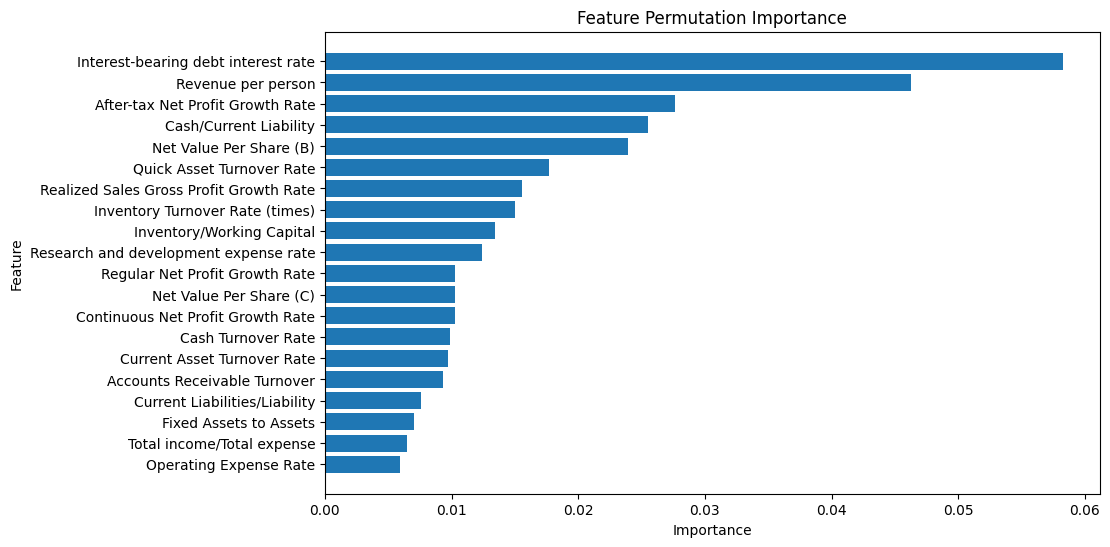

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  After-tax Net Profit Growth Rate
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'After-tax Net Profit Growth Rate']

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'After-tax Net Profit Growth Rate', 'Cash/Current Liability']

--- NEW ITERATION ---
Removing feature:  Net Value Per Share (B)
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'After-tax Net Profit Growth Rate', 'Cash/Current Liability', 'Net Value Per Share (B)']

--- NEW ITERATION ---
Re

In [ ]:
xgb_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   20  1303  17  24      54.05   45.45        98.71     96.99     49.38   
1   11  1308  12  33      47.83   25.00        99.09     96.70     32.84   
2   13  1306  14  31      48.15   29.55        98.94     96.70     36.62   
3   16  1303  17  28      48.48   36.36        98.71     96.70     41.56   
4   16  1302  18  28      47.06   36.36        98.64     96.63     41.03   
5   17  1301  19  27      47.22   38.64        98.56     96.63     42.50   
6   18  1300  20  26      47.37   40.91        98.48     96.63     43.90   
7   19  1300  20  25      48.72   43.18        98.48     96.70     45.78   
8   15  1304  16  29      48.39   34.09        98.79     96.70     40.00   
9   15  1304  16  29      48.39   34.09        98.79     96.70     40.00   
10  16  1305  15  28      51.61   36.36        98.86     96.85     42.67   
11  17  1303  17  27      50.00   38.64        98.71     96.77     43.59   
12  17  1301  19  27      47.22   38.64        98.56     96.63     42.50   
13  18  1300  20  26      47.37   40.91        98.48     96.63     43.90   
14  18  1301  19  26      48.65   40.91        98.56     96.70     44.44   
15  18  1299  21  26      46.15   40.91        98.41     96.55     43.37   
16  17  1300  20  27      45.95   38.64        98.48     96.55     41.98   
17  16  1300  20  28      44.44   36.36        98.48     96.48     40.00   
18  16  1300  20  28      44.44   36.36        98.48     96.48     40.00   
19  15  1302  18  29      45.45   34.09        98.64     96.55     38.96   
20  15  1302  18  29      45.45   34.09        98.64     96.55     38.96   

    balanced_accuracy  num_feat_missing  \
0               72.08                 0   
1               62.05                 1   
2               64.24                 2   
3               67.54                 3   
4               67.50                 4   
5               68.60                 5   
6               69.70                 6   
7               70.83                 7   
8               66.44                 8   
9               66.44                 9   
10              67.61                10   
11              68.67                11   
12              68.60                12   
13              69.70                13   
14              69.73                14   
15              69.66                15   
16              68.56                16   
17              67.42                17   
18              67.42                18   
19              66.36                19   
20              66.36                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Reven...  
3   ['Interest-bearing debt interest rate', 'Reven...  
4   ['Interest-bearing debt interest rate', 'Reven...  
5   ['Interest-bearing debt interest rate', 'Reven...  
6   ['Interest-bearing debt interest rate', 'Reven...  
7   ['Interest-bearing debt interest rate', 'Reven...  
8   ['Interest-bearing debt interest rate', 'Reven...  
9   ['Interest-bearing debt interest rate', 'Reven...  
10  ['Interest-bearing debt interest rate', 'Reven...  
11  ['Interest-bearing debt interest rate', 'Reven...  
12  ['Interest-bearing debt interest rate', 'Reven...  
13  ['Interest-bearing debt interest rate', 'Reven...  
14  ['Interest-bearing debt interest rate', 'Reven...  
15  ['Interest-bearing debt interest rate', 'Reven...  
16  ['Interest-bearing debt interest rate', 'Reven...  
17  ['Interest-bearing debt interest rate', 'Reven...  
18  ['Interest-bearing debt interest rate', 'Reven...  
19  ['Interest-bearing debt interest rate', 'Reven...  
20  ['Interest-bearing debt interest rate', 'Reven...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:21:42.378384

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growt

In [ ]:
xgb_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   20  1303  17  24      54.05   45.45        98.71     96.99     49.38   
1   25  1294  26  19      49.02   56.82        98.03     96.70     52.63   
2   26  1284  36  18      41.94   59.09        97.27     96.04     49.06   
3   26  1285  35  18      42.62   59.09        97.35     96.11     49.52   
4   25  1283  37  19      40.32   56.82        97.20     95.89     47.17   
5   25  1281  39  19      39.06   56.82        97.05     95.75     46.30   
6   27  1281  39  17      40.91   61.36        97.05     95.89     49.09   
7   25  1281  39  19      39.06   56.82        97.05     95.75     46.30   
8   25  1281  39  19      39.06   56.82        97.05     95.75     46.30   
9   25  1286  34  19      42.37   56.82        97.42     96.11     48.54   
10  25  1283  37  19      40.32   56.82        97.20     95.89     47.17   
11  26  1283  37  18      41.27   59.09        97.20     95.97     48.60   
12  28  1284  36  16      43.75   63.64        97.27     96.19     51.85   
13  27  1281  39  17      40.91   61.36        97.05     95.89     49.09   
14  31  1277  43  13      41.89   70.45        96.74     95.89     52.54   
15  30  1277  43  14      41.10   68.18        96.74     95.82     51.28   
16  26  1283  37  18      41.27   59.09        97.20     95.97     48.60   
17  25  1285  35  19      41.67   56.82        97.35     96.04     48.08   
18  26  1286  34  18      43.33   59.09        97.42     96.19     50.00   
19  27  1284  36  17      42.86   61.36        97.27     96.11     50.47   
20  30  1279  41  14      42.25   68.18        96.89     95.97     52.17   

    balanced_accuracy  num_feat_missing  \
0               72.08                 0   
1               77.42                 1   
2               78.18                 2   
3               78.22                 3   
4               77.01                 4   
5               76.93                 5   
6               79.20                 6   
7               76.93                 7   
8               76.93                 8   
9               77.12                 9   
10              77.01                10   
11              78.14                11   
12              80.45                12   
13              79.20                13   
14              83.60                14   
15              82.46                15   
16              78.14                16   
17              77.08                17   
18              78.26                18   
19              79.32                19   
20              82.54                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Reven...  
3   ['Interest-bearing debt interest rate', 'Reven...  
4   ['Interest-bearing debt interest rate', 'Reven...  
5   ['Interest-bearing debt interest rate', 'Reven...  
6   ['Interest-bearing debt interest rate', 'Reven...  
7   ['Interest-bearing debt interest rate', 'Reven...  
8   ['Interest-bearing debt interest rate', 'Reven...  
9   ['Interest-bearing debt interest rate', 'Reven...  
10  ['Interest-bearing debt interest rate', 'Reven...  
11  ['Interest-bearing debt interest rate', 'Reven...  
12  ['Interest-bearing debt interest rate', 'Reven...  
13  ['Interest-bearing debt interest rate', 'Reven...  
14  ['Interest-bearing debt interest rate', 'Reven...  
15  ['Interest-bearing debt interest rate', 'Reven...  
16  ['Interest-bearing debt interest rate', 'Reven...  
17  ['Interest-bearing debt interest rate', 'Reven...  
18  ['Interest-bearing debt interest rate', 'Reven...  
19  ['Interest-bearing debt interest rate', 'Reven...  
20  ['Interest-bearing debt interest rate', 'Reven...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et_param_grid = {
      'n_estimators': [300],
      'max_depth': [None],
      'max_features':[0.5],
      'min_samples_split': [0.001],
      'min_samples_leaf': [0.001]
  }

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:31:11.505715

Nested Cross-validation Results:
Individual scores: [0.41441441 0.51282051 0.46428571]
Average nested CV score: 0.464 (+/- 0.080)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.001, 'min_samples_split': 0.001, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.464
2025-01-16 11:31:23.922607

Execution time: 0.21 minutes




```
Starting hyperparameter tuning at: 2025-01-15 14:05:19.263655

Nested Cross-validation Results:
Individual scores: [0.46341463 0.38043478 0.48780488]
Average nested CV score: 0.444 (+/- 0.092)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.001, 'min_samples_split': 0.001, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.464

Train score: 0.943
Test score: 0.464
Train-test score difference: 0.479
2025-01-15 14:29:14.745077

Execution time: 23.92 minutes
```



In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
5                     Operating Profit Rate    0.004167  0.000846
50                       Revenue per person    0.003820  0.001295
71                Quick Asset Turnover Rate    0.003817  0.002022
40         Contingent liabilities/Net worth    0.003475  0.001095
41         Operating profit/Paid-in capital    0.003472  0.001900
..                                      ...         ...       ...
39                     Borrowing dependency   -0.040411  0.004027
36                             Debt ratio %   -0.049405  0.005506
93                      Equity to Liability   -0.054969  0.005720
18  Persistent EPS in the Last Four Seasons   -0.062207  0.003866
37                         Net worth/Assets   -0.066731  0.006027

[89 rows x 3 columns]

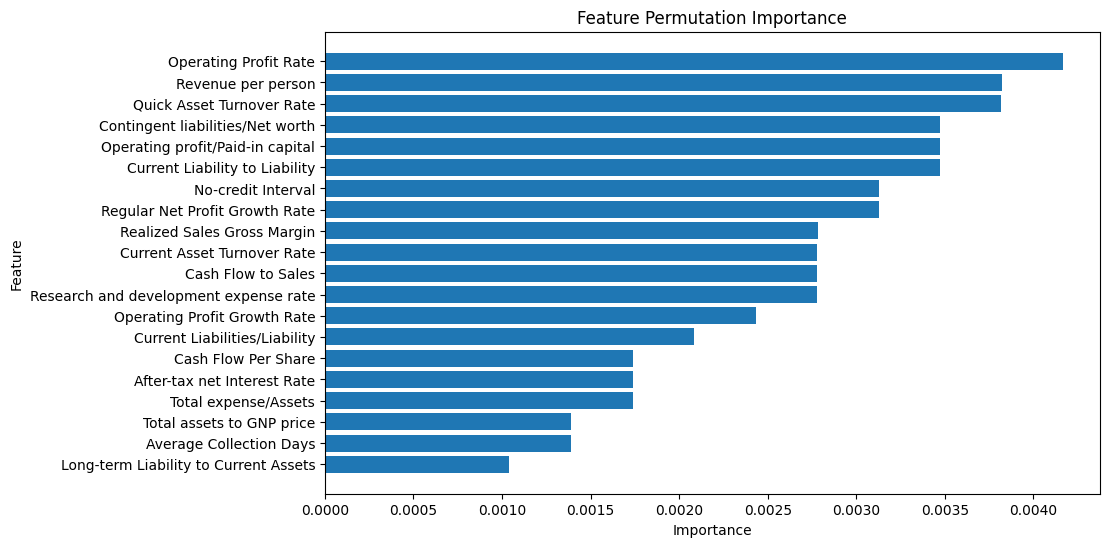

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Operating Profit Rate
Original feat removed so far:  ['Operating Profit Rate']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Operating Profit Rate', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Operating Profit Rate', 'Revenue per person', 'Quick Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Contingent liabilities/Net worth
Original feat removed so far:  ['Operating Profit Rate', 'Revenue per person', 'Quick Asset Turnover Rate', 'Contingent liabilities/Net worth']

--- NEW ITERATION ---
Removing feature:  Operating profit/Paid-in capital
Original feat removed so far:  ['Operating Profit Rate', 'Revenue per person', 'Quick Asset Turnover Rate', 'Contingent liabilities/Net worth', 'Operating profit/Paid-in capital']

--- NEW ITERATION ---
Removing feature:  Current Liability to Liability
Original feat re

In [ ]:
et_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
1   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
2   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
3   22  1294  26  22      45.83   50.00        98.03     96.48     47.83   
4   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
5   22  1293  27  22      44.90   50.00        97.95     96.41     47.31   
6   23  1292  28  21      45.10   52.27        97.88     96.41     48.42   
7   23  1292  28  21      45.10   52.27        97.88     96.41     48.42   
8   22  1292  28  22      44.00   50.00        97.88     96.33     46.81   
9   22  1292  28  22      44.00   50.00        97.88     96.33     46.81   
10  22  1291  29  22      43.14   50.00        97.80     96.26     46.32   
11  23  1290  30  21      43.40   52.27        97.73     96.26     47.42   
12  23  1290  30  21      43.40   52.27        97.73     96.26     47.42   
13  23  1290  30  21      43.40   52.27        97.73     96.26     47.42   
14  23  1290  30  21      43.40   52.27        97.73     96.26     47.42   
15  23  1291  29  21      44.23   52.27        97.80     96.33     47.92   
16  23  1290  30  21      43.40   52.27        97.73     96.26     47.42   
17  23  1290  30  21      43.40   52.27        97.73     96.26     47.42   
18  22  1290  30  22      42.31   50.00        97.73     96.19     45.83   
19  22  1291  29  22      43.14   50.00        97.80     96.26     46.32   
20  22  1291  29  22      43.14   50.00        97.80     96.26     46.32   

    balanced_accuracy  num_feat_missing  \
0               74.05                 0   
1               74.05                 1   
2               74.05                 2   
3               74.02                 3   
4               74.05                 4   
5               73.98                 5   
6               75.08                 6   
7               75.08                 7   
8               73.94                 8   
9               73.94                 9   
10              73.90                10   
11              75.00                11   
12              75.00                12   
13              75.00                13   
14              75.00                14   
15              75.04                15   
16              75.00                16   
17              75.00                17   
18              73.86                18   
19              73.90                19   
20              73.90                20   

                                              imputed  
0                                                      
1                   ['Operating Profit Rate'] imputed  
2   ['Operating Profit Rate', 'Revenue per person'...  
3   ['Operating Profit Rate', 'Revenue per person'...  
4   ['Operating Profit Rate', 'Revenue per person'...  
5   ['Operating Profit Rate', 'Revenue per person'...  
6   ['Operating Profit Rate', 'Revenue per person'...  
7   ['Operating Profit Rate', 'Revenue per person'...  
8   ['Operating Profit Rate', 'Revenue per person'...  
9   ['Operating Profit Rate', 'Revenue per person'...  
10  ['Operating Profit Rate', 'Revenue per person'...  
11  ['Operating Profit Rate', 'Revenue per person'...  
12  ['Operating Profit Rate', 'Revenue per person'...  
13  ['Operating Profit Rate', 'Revenue per person'...  
14  ['Operating Profit Rate', 'Revenue per person'...  
15  ['Operating Profit Rate', 'Revenue per person'...  
16  ['Operating Profit Rate', 'Revenue per person'...  
17  ['Operating Profit Rate', 'Revenue per person'...  
18  ['Operating Profit Rate', 'Revenue per person'...  
19  ['Operating Profit Rate', 'Revenue per person'...  
20  ['Operating Profit Rate', 'Revenue per person'...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:31:37.602225

--- NEW ITERATION ---
Removing feature:  Operating Profit Rate
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'Afte

In [ ]:
et_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
1   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
2   22  1294  26  22      45.83   50.00        98.03     96.48     47.83   
3   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
4   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
5   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
6   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
7   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
8   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
9   22  1295  25  22      46.81   50.00        98.11     96.55     48.35   
10  23  1295  25  21      47.92   52.27        98.11     96.63     50.00   
11  23  1294  26  21      46.94   52.27        98.03     96.55     49.46   
12  23  1293  27  21      46.00   52.27        97.95     96.48     48.94   
13  23  1294  26  21      46.94   52.27        98.03     96.55     49.46   
14  24  1293  27  20      47.06   54.55        97.95     96.55     50.53   
15  24  1293  27  20      47.06   54.55        97.95     96.55     50.53   
16  24  1293  27  20      47.06   54.55        97.95     96.55     50.53   
17  24  1293  27  20      47.06   54.55        97.95     96.55     50.53   
18  25  1291  29  19      46.30   56.82        97.80     96.48     51.02   
19  25  1291  29  19      46.30   56.82        97.80     96.48     51.02   
20  25  1291  29  19      46.30   56.82        97.80     96.48     51.02   

    balanced_accuracy  num_feat_missing  \
0               74.05                 0   
1               74.05                 1   
2               74.02                 2   
3               74.05                 3   
4               74.05                 4   
5               74.05                 5   
6               74.05                 6   
7               74.05                 7   
8               74.05                 8   
9               74.05                 9   
10              75.19                10   
11              75.15                11   
12              75.11                12   
13              75.15                13   
14              76.25                14   
15              76.25                15   
16              76.25                16   
17              76.25                17   
18              77.31                18   
19              77.31                19   
20              77.31                20   

                                              imputed  
0                                                      
1                   ['Operating Profit Rate'] imputed  
2   ['Operating Profit Rate', 'Revenue per person'...  
3   ['Operating Profit Rate', 'Revenue per person'...  
4   ['Operating Profit Rate', 'Revenue per person'...  
5   ['Operating Profit Rate', 'Revenue per person'...  
6   ['Operating Profit Rate', 'Revenue per person'...  
7   ['Operating Profit Rate', 'Revenue per person'...  
8   ['Operating Profit Rate', 'Revenue per person'...  
9   ['Operating Profit Rate', 'Revenue per person'...  
10  ['Operating Profit Rate', 'Revenue per person'...  
11  ['Operating Profit Rate', 'Revenue per person'...  
12  ['Operating Profit Rate', 'Revenue per person'...  
13  ['Operating Profit Rate', 'Revenue per person'...  
14  ['Operating Profit Rate', 'Revenue per person'...  
15  ['Operating Profit Rate', 'Revenue per person'...  
16  ['Operating Profit Rate', 'Revenue per person'...  
17  ['Operating Profit Rate', 'Revenue per person'...  
18  ['Operating Profit Rate', 'Revenue per person'...  
19  ['Operating Profit Rate', 'Revenue per person'...  
20  ['Operating Profit Rate', 'Revenue per person'...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, taiwan_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = taiwan_scaler)

In [ ]:
taiwan_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.1, 1, 2, 3, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm_param_grid = {
    'C': [20],
    'kernel': ['poly'],
    'gamma': ['scale'],
    'degree': [5]
}

svm_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 3, 3, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:41:10.835369

Nested Cross-validation Results:
Individual scores: [0.31764706 0.30337079 0.32298137]
Average nested CV score: 0.315 (+/- 0.017)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 20, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.315
2025-01-16 11:41:15.660727

Execution time: 0.08 minutes




```
Starting hyperparameter tuning at: 2025-01-15 14:29:14.789148

Nested Cross-validation Results:
Individual scores: [0.18333333 0.28571429 0.32298137]
Average nested CV score: 0.264 (+/- 0.118)

Fitting final model on entire dataset...
Fitting 3 folds for each of 420 candidates, totalling 1260 fits
Best parameters: {'C': 20, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.315

Train score: 0.687
Test score: 0.315
Train-test score difference: 0.372
2025-01-15 14:35:58.711103

Execution time: 6.73 minutes
```



In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1")
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
54                Quick Assets/Total Assets    0.123802  0.009396
18  Persistent EPS in the Last Four Seasons    0.120685  0.012043
55              Current Assets/Total Assets    0.114292  0.018172
71                Quick Asset Turnover Rate    0.104924  0.008014
44                     Total Asset Turnover    0.091467  0.005477
..                                      ...         ...       ...
3                    Operating Gross Margin   -0.001862  0.001344
53          Working Capital to Total Assets   -0.002095  0.006250
68               Total income/Total expense   -0.007545  0.002066
15                  Net Value Per Share (B)   -0.010248  0.003822
93                      Equity to Liability   -0.015290  0.006698

[84 rows x 3 columns]

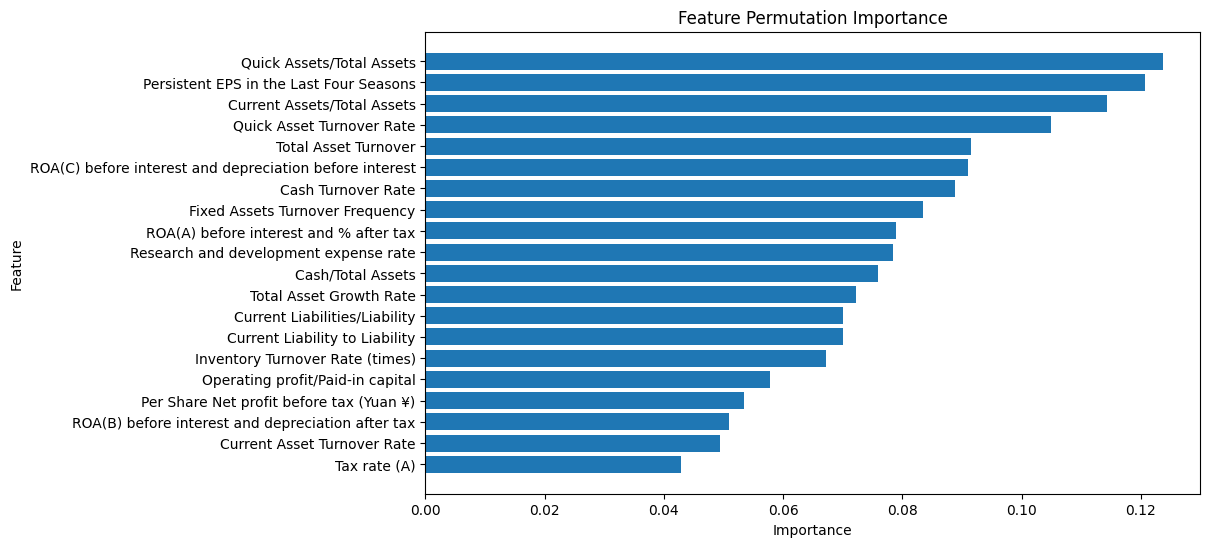

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    taiwan_imputation_scaled_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Original feat removed so far:  ['Quick Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Persistent EPS in the Last Four Seasons
Original feat removed so far:  ['Quick Assets/Total Assets', 'Persistent EPS in the Last Four Seasons']

--- NEW ITERATION ---
Removing feature:  Current Assets/Total Assets
Original feat removed so far:  ['Quick Assets/Total Assets', 'Persistent EPS in the Last Four Seasons', 'Current Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Quick Assets/Total Assets', 'Persistent EPS in the Last Four Seasons', 'Current Assets/Total Assets', 'Quick Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Quick Assets/Total Assets', 'Persistent EPS in the Last Four Seasons', 'Current Assets/Total Assets', 'Quick Asset Turnover Rate', 'Total Asset Turnover

In [ ]:
svm_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1252   68  22      24.44   50.00        94.85     93.40     32.84   
1   29  1219  101  15      22.31   65.91        92.35     91.50     33.33   
2   23  1234   86  21      21.10   52.27        93.48     92.16     30.07   
3   23  1231   89  21      20.54   52.27        93.26     91.94     29.49   
4   21  1235   85  23      19.81   47.73        93.56     92.08     28.00   
5   19  1252   68  25      21.84   43.18        94.85     93.18     29.01   
6    9  1260   60  35      13.04   20.45        95.45     93.04     15.93   
7   11  1248   72  33      13.25   25.00        94.55     92.30     17.32   
8   11  1247   73  33      13.10   25.00        94.47     92.23     17.19   
9   13  1247   73  31      15.12   29.55        94.47     92.38     20.00   
10  15  1233   87  29      14.71   34.09        93.41     91.50     20.55   
11   6  1258   62  38       8.82   13.64        95.30     92.67     10.71   
12  10  1225   95  34       9.52   22.73        92.80     90.54     13.42   
13  11  1192  128  33       7.91   25.00        90.30     88.20     12.02   
14  12  1179  141  32       7.84   27.27        89.32     87.32     12.18   
15  13  1137  183  31       6.63   29.55        86.14     84.31     10.83   
16  18  1166  154  26      10.47   40.91        88.33     86.80     16.67   
17  23  1173  147  21      13.53   52.27        88.86     87.68     21.50   
18  31  1146  174  13      15.12   70.45        86.82     86.29     24.90   
19  31  1154  166  13      15.74   70.45        87.42     86.88     25.73   
20  29  1156  164  15      15.03   65.91        87.58     86.88     24.47   

    balanced_accuracy  num_feat_missing  \
0               72.42                 0   
1               79.13                 1   
2               72.88                 2   
3               72.77                 3   
4               70.64                 4   
5               69.02                 5   
6               57.95                 6   
7               59.77                 7   
8               59.73                 8   
9               62.01                 9   
10              63.75                10   
11              54.47                11   
12              57.77                12   
13              57.65                13   
14              58.30                14   
15              57.84                15   
16              64.62                16   
17              70.57                17   
18              78.64                18   
19              78.94                19   
20              76.74                20   

                                              imputed  
0                                                      
1               ['Quick Assets/Total Assets'] imputed  
2   ['Quick Assets/Total Assets', 'Persistent EPS ...  
3   ['Quick Assets/Total Assets', 'Persistent EPS ...  
4   ['Quick Assets/Total Assets', 'Persistent EPS ...  
5   ['Quick Assets/Total Assets', 'Persistent EPS ...  
6   ['Quick Assets/Total Assets', 'Persistent EPS ...  
7   ['Quick Assets/Total Assets', 'Persistent EPS ...  
8   ['Quick Assets/Total Assets', 'Persistent EPS ...  
9   ['Quick Assets/Total Assets', 'Persistent EPS ...  
10  ['Quick Assets/Total Assets', 'Persistent EPS ...  
11  ['Quick Assets/Total Assets', 'Persistent EPS ...  
12  ['Quick Assets/Total Assets', 'Persistent EPS ...  
13  ['Quick Assets/Total Assets', 'Persistent EPS ...  
14  ['Quick Assets/Total Assets', 'Persistent EPS ...  
15  ['Quick Assets/Total Assets', 'Persistent EPS ...  
16  ['Quick Assets/Total Assets', 'Persistent EPS ...  
17  ['Quick Assets/Total Assets', 'Persistent EPS ...  
18  ['Quick Assets/Total Assets', 'Persistent EPS ...  
19  ['Quick Assets/Total Assets', 'Persistent EPS ...  
20  ['Quick Assets/Total Assets', 'Persistent EPS ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:41:35.012890

--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', '

In [ ]:
svm_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1252   68  22      24.44   50.00        94.85     93.40     32.84   
1   25  1243   77  19      24.51   56.82        94.17     92.96     34.25   
2   25  1243   77  19      24.51   56.82        94.17     92.96     34.25   
3   27  1238   82  17      24.77   61.36        93.79     92.74     35.29   
4   30  1201  119  14      20.13   68.18        90.98     90.25     31.09   
5   30  1210  110  14      21.43   68.18        91.67     90.91     32.61   
6   29  1215  105  15      21.64   65.91        92.05     91.20     32.58   
7   30  1200  120  14      20.00   68.18        90.91     90.18     30.93   
8   30  1195  125  14      19.35   68.18        90.53     89.81     30.15   
9   30  1200  120  14      20.00   68.18        90.91     90.18     30.93   
10  31  1199  121  13      20.39   70.45        90.83     90.18     31.63   
11  32  1209  111  12      22.38   72.73        91.59     90.98     34.22   
12  33  1175  145  11      18.54   75.00        89.02     88.56     29.73   
13  34  1168  152  10      18.28   77.27        88.48     88.12     29.57   
14  35  1139  181   9      16.20   79.55        86.29     86.07     26.92   
15  38  1136  184   6      17.12   86.36        86.06     86.07     28.57   
16  38  1136  184   6      17.12   86.36        86.06     86.07     28.57   
17  38  1140  180   6      17.43   86.36        86.36     86.36     29.01   
18  37  1149  171   7      17.79   84.09        87.05     86.95     29.37   
19  39  1118  202   5      16.18   88.64        84.70     84.82     27.37   
20  37  1142  178   7      17.21   84.09        86.52     86.44     28.57   

    balanced_accuracy  num_feat_missing  \
0               72.42                 0   
1               75.49                 1   
2               75.49                 2   
3               77.58                 3   
4               79.58                 4   
5               79.92                 5   
6               78.98                 6   
7               79.55                 7   
8               79.36                 8   
9               79.55                 9   
10              80.64                10   
11              82.16                11   
12              82.01                12   
13              82.88                13   
14              82.92                14   
15              86.21                15   
16              86.21                16   
17              86.36                17   
18              85.57                18   
19              86.67                19   
20              85.30                20   

                                              imputed  
0                                                      
1               ['Quick Assets/Total Assets'] imputed  
2   ['Quick Assets/Total Assets', 'Persistent EPS ...  
3   ['Quick Assets/Total Assets', 'Persistent EPS ...  
4   ['Quick Assets/Total Assets', 'Persistent EPS ...  
5   ['Quick Assets/Total Assets', 'Persistent EPS ...  
6   ['Quick Assets/Total Assets', 'Persistent EPS ...  
7   ['Quick Assets/Total Assets', 'Persistent EPS ...  
8   ['Quick Assets/Total Assets', 'Persistent EPS ...  
9   ['Quick Assets/Total Assets', 'Persistent EPS ...  
10  ['Quick Assets/Total Assets', 'Persistent EPS ...  
11  ['Quick Assets/Total Assets', 'Persistent EPS ...  
12  ['Quick Assets/Total Assets', 'Persistent EPS ...  
13  ['Quick Assets/Total Assets', 'Persistent EPS ...  
14  ['Quick Assets/Total Assets', 'Persistent EPS ...  
15  ['Quick Assets/Total Assets', 'Persistent EPS ...  
16  ['Quick Assets/Total Assets', 'Persistent EPS ...  
17  ['Quick Assets/Total Assets', 'Persistent EPS ...  
18  ['Quick Assets/Total Assets', 'Persistent EPS ...  
19  ['Quick Assets/Total Assets', 'Persistent EPS ...  
20  ['Quick Assets/Total Assets', 'Persistent EPS ...

##**Logistic Regression**

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicollinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_taiwan_dist_corr = taiwan_dist_corr[present_features]
filtered_taiwan_dist_corr = filtered_taiwan_dist_corr[filtered_taiwan_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_taiwan_dist_corr, 'Target', 0.8)

appended feature:  Net Income to Stockholder's Equity
eliminated feature:  Net Income to Total Assets 0.8973633447055411
eliminated feature:  ROA(A) before interest and % after tax 0.8889656438588007
eliminated feature:  Persistent EPS in the Last Four Seasons 0.8418923446221166
eliminated feature:  ROA(B) before interest and depreciation after tax 0.825242033356963
eliminated feature:  Net profit before tax/Paid-in capital 0.84275281712983
eliminated feature:  Per Share Net profit before tax (Yuan ¥) 0.8389737564714317
eliminated feature:  ROA(C) before interest and depreciation before interest 0.8112170983279147
appended feature:  Borrowing dependency
eliminated feature:  Liability to Equity 0.8572090276554882
appended feature:  Retained Earnings to Total Assets
appended feature:  Current Liability to Equity
eliminated feature:  Current Liabilities/Equity 0.9999999999736582
eliminated feature:  Debt ratio % 0.853558719131654
eliminated feature:  Net worth/Assets 0.8535587191307598
el

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]

In [ ]:
print('Nr. features for Logistic Regression: ', len(lr_X_train.columns))

Nr. features for Logistic Regression:  64


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],  # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
  }
else:
  lr_param_grid = {
      'C': [10],
      'penalty': ['l1'],
      'solver': ['liblinear']
  }

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 3, 3, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:50:05.518873

Nested Cross-validation Results:
Individual scores: [0.26900585 0.23529412 0.26595745]
Average nested CV score: 0.257 (+/- 0.030)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.257
2025-01-16 11:51:26.412486

Execution time: 1.35 minutes


```
Starting hyperparameter tuning at: 2025-01-15 14:35:59.643591

Nested Cross-validation Results:
Individual scores: [0.26900585 0.21195652 0.18095238]
Average nested CV score: 0.221 (+/- 0.073)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.257

Train score: 0.302
Test score: 0.257
Train-test score difference: 0.045
2025-01-15 14:38:25.747942

Execution time: 2.44 minutes
```



In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
13                          Equity to Liability    0.050750  0.009315
32                       Cash Flow to Liability    0.015584  0.006300
52               Current Liability to Liability    0.014699  0.003304
31                    Quick Assets/Total Assets    0.013799  0.003112
23  Inventory and accounts receivable/Net value    0.013582  0.003914
19                         Total expense/Assets    0.011729  0.002427
46                           Cash Turnover Rate    0.009698  0.003904
56              Inventory Turnover Rate (times)    0.008708  0.002937
26                          Cash Flow to Equity    0.008469  0.004035
6                    Total income/Total expense    0.005095  0.008938
12                Equity to Long-term Liability    0.004866  0.001275
55                       Operating Expense Rate    0.004740  0.001318
15                        Liability-Assets Flag    0.004640  0.000131
47        Research and development expense rate    0.003332  0.001347
50                    Quick Asset Turnover Rate    0.003182  0.002760
25             After-tax Net Profit Growth Rate    0.002916  0.000200
60                 Accounts Receivable Turnover    0.001782  0.000781
51                   Total debt/Total net worth    0.001715  0.000866
54                  Current Asset Turnover Rate    0.001547  0.000952
1                          Borrowing dependency    0.001543  0.003184
33                    Inventory/Working Capital    0.001219  0.000766
42         Long-term fund suitability ratio (A)    0.001156  0.000776
30           Degree of Financial Leverage (DFL)    0.000456  0.000820
14                                 Tax rate (A)    0.000428  0.001081
48                    Total assets to GNP price    0.000428  0.000595
17                       Interest Expense Ratio    0.000381  0.000133
61                      Average Collection Days    0.000364  0.000800
35                         Total Asset Turnover    0.000289  0.004416
58                  Inventory/Current Liability    0.000218  0.000109
41            Continuous Net Profit Growth Rate    0.000109  0.000133
37                 Operating Profit Growth Rate    0.000109  0.000133
44                           Cash Flow to Sales    0.000109  0.000133
29                           No-credit Interval    0.000053  0.000609
62               Quick Assets/Current Liability   -0.000055  0.000109
4           Current Liability to Current Assets   -0.000072  0.000612
0            Net Income to Stockholder's Equity   -0.000109  0.000219
57                   Allocation rate per person   -0.000109  0.000278
45      Realized Sales Gross Profit Growth Rate   -0.000164  0.000134
59        Long-term Liability to Current Assets   -0.000218  0.000109
22                          Cash Flow Per Share   -0.000218  0.000204
39                      Total Asset Growth Rate   -0.000292  0.000816
28                       Cash/Current Liability   -0.000492  0.000319
53          Interest-bearing debt interest rate   -0.000522  0.001124
9           Operating Profit Per Share (Yuan ¥)   -0.000567  0.002516
36              Fixed Assets Turnover Frequency   -0.000750  0.002033
11                  Operating profit per person   -0.000995  0.001570
16                       Operating Gross Margin   -0.001154  0.002774
24                            Cash/Total Assets   -0.001273  0.005961
21                               Cash flow rate   -0.002012  0.001568
2             Retained Earnings to Total Assets   -0.004342  0.004963
7                       Net Value Per Share (A)   -0.004450  0.004306

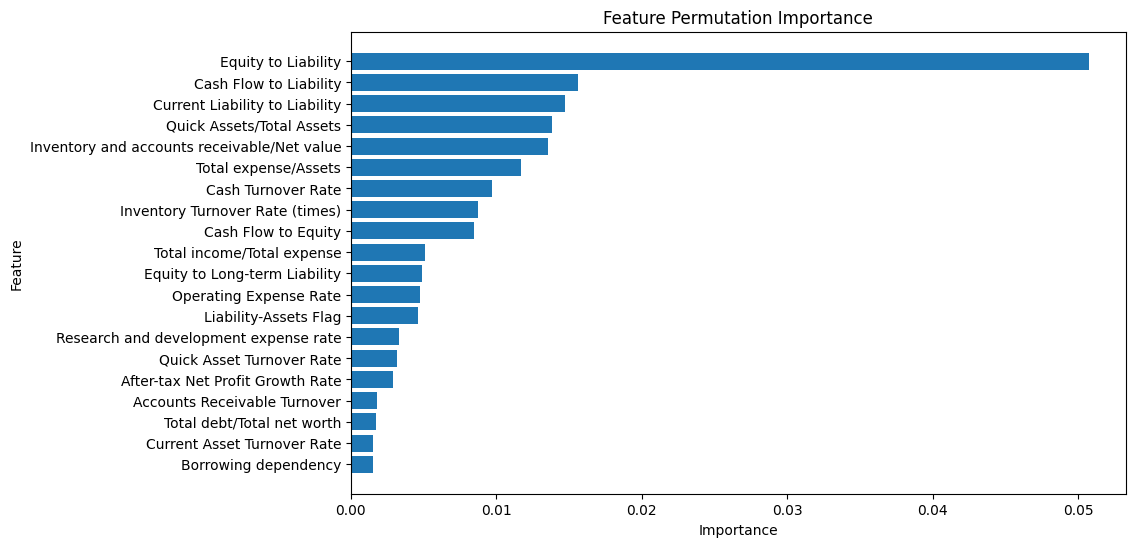

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Liability
Original feat removed so far:  ['Equity to Liability', 'Cash Flow to Liability']

--- NEW ITERATION ---
Removing feature:  Current Liability to Liability
Original feat removed so far:  ['Equity to Liability', 'Cash Flow to Liability', 'Current Liability to Liability']

--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Original feat removed so far:  ['Equity to Liability', 'Cash Flow to Liability', 'Current Liability to Liability', 'Quick Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Inventory and accounts receivable/Net value
Original feat removed so far:  ['Equity to Liability', 'Cash Flow to Liability', 'Current Liability to Liability', 'Quick Assets/Total Assets', 'Inventory and accounts receivable/Net value']

--- NEW ITERATION ---
Removing feature:  Total expense/Asse

In [ ]:
lr_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1165  155   8      18.85   81.82        88.26     88.05     30.64   
1   33  1173  147  11      18.33   75.00        88.86     88.42     29.46   
2   31  1186  134  13      18.79   70.45        89.85     89.22     29.67   
3   33  1176  144  11      18.64   75.00        89.09     88.64     29.86   
4   36  1169  151   8      19.25   81.82        88.56     88.34     31.17   
5   36  1164  156   8      18.75   81.82        88.18     87.98     30.51   
6   36  1166  154   8      18.95   81.82        88.33     88.12     30.77   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               85.04                 0   
1               81.93                 1   
2               80.15                 2   
3               82.05                 3   
4               85.19                 4   
5               85.00                 5   
6               85.08                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Cash Flow to Liabilit...  
3   ['Equity to Liability', 'Cash Flow to Liabilit...  
4   ['Equity to Liability', 'Cash Flow to Liabilit...  
5   ['Equity to Liability', 'Cash Flow to Liabilit...  
6   ['Equity to Liability', 'Cash Flow to Liabilit...  
7   ['Equity to Liability', 'Cash Flow to Liabilit...  
8   ['Equity to Liability', 'Cash Flow to Liabilit...  
9   ['Equity to Liability', 'Cash Flow to Liabilit...  
10  ['Equity to Liability', 'Cash Flow to Liabilit...  
11  ['Equity to Liability', 'Cash Flow to Liabilit...  
12  ['Equity to Liability', 'Cash Flow to Liabilit...  
13  ['Equity to Liability', 'Cash Flow to Liabilit...  
14  ['Equity to Liability', 'Cash Flow to Liabilit...  
15  ['Equity to Liability', 'Cash Flow to Liabilit...  
16  ['Equity to Liability', 'Cash Flow to Liabilit...  
17  ['Equity to Liability', 'Cash Flow to Liabilit...  
18  ['Equity to Liability', 'Cash Flow to Liabilit...  
19  ['Equity to Liability', 'Cash Flow to Liabilit...  
20  ['Equity to Liability', 'Cash Flow to Liabilit...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:51:49.954705

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate', 'Cash/Curren

In [ ]:
lr_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1165  155   8      18.85   81.82        88.26     88.05     30.64   
1   36  1184  136   8      20.93   81.82        89.70     89.44     33.33   
2   36  1186  134   8      21.18   81.82        89.85     89.59     33.64   
3   36  1186  134   8      21.18   81.82        89.85     89.59     33.64   
4   36  1188  132   8      21.43   81.82        90.00     89.74     33.96   
5   36  1187  133   8      21.30   81.82        89.92     89.66     33.80   
6   35  1187  133   9      20.83   79.55        89.92     89.59     33.02   
7   35  1184  136   9      20.47   79.55        89.70     89.37     32.56   
8   34  1186  134  10      20.24   77.27        89.85     89.44     32.08   
9   33  1185  135  11      19.64   75.00        89.77     89.30     31.13   
10  34  1185  135  10      20.12   77.27        89.77     89.37     31.92   
11  34  1185  135  10      20.12   77.27        89.77     89.37     31.92   
12  34  1181  139  10      19.65   77.27        89.47     89.08     31.34   
13  33  1181  139  11      19.19   75.00        89.47     89.00     30.56   
14  35  1180  140   9      20.00   79.55        89.39     89.08     31.96   
15  34  1176  144  10      19.10   77.27        89.09     88.71     30.63   
16  36  1178  142   8      20.22   81.82        89.24     89.00     32.43   
17  36  1178  142   8      20.22   81.82        89.24     89.00     32.43   
18  36  1178  142   8      20.22   81.82        89.24     89.00     32.43   
19  36  1167  153   8      19.05   81.82        88.41     88.20     30.90   
20  32  1187  133  12      19.39   72.73        89.92     89.37     30.62   

    balanced_accuracy  num_feat_missing  \
0               85.04                 0   
1               85.76                 1   
2               85.83                 2   
3               85.83                 3   
4               85.91                 4   
5               85.87                 5   
6               84.73                 6   
7               84.62                 7   
8               83.56                 8   
9               82.39                 9   
10              83.52                10   
11              83.52                11   
12              83.37                12   
13              82.23                13   
14              84.47                14   
15              83.18                15   
16              85.53                16   
17              85.53                17   
18              85.53                18   
19              85.11                19   
20              81.33                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Cash Flow to Liabilit...  
3   ['Equity to Liability', 'Cash Flow to Liabilit...  
4   ['Equity to Liability', 'Cash Flow to Liabilit...  
5   ['Equity to Liability', 'Cash Flow to Liabilit...  
6   ['Equity to Liability', 'Cash Flow to Liabilit...  
7   ['Equity to Liability', 'Cash Flow to Liabilit...  
8   ['Equity to Liability', 'Cash Flow to Liabilit...  
9   ['Equity to Liability', 'Cash Flow to Liabilit...  
10  ['Equity to Liability', 'Cash Flow to Liabilit...  
11  ['Equity to Liability', 'Cash Flow to Liabilit...  
12  ['Equity to Liability', 'Cash Flow to Liabilit...  
13  ['Equity to Liability', 'Cash Flow to Liabilit...  
14  ['Equity to Liability', 'Cash Flow to Liabilit...  
15  ['Equity to Liability', 'Cash Flow to Liabilit...  
16  ['Equity to Liability', 'Cash Flow to Liabilit...  
17  ['Equity to Liability', 'Cash Flow to Liabilit...  
18  ['Equity to Liability', 'Cash Flow to Liabilit...  
19  ['Equity to Liability', 'Cash Flow to Liabilit...  
20  ['Equity to Liability', 'Cash Flow to Liabilit...

# **Models optimized for Balanced Accuracy**

##**Decision tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [4],
      'min_samples_split': [0.1],
      'min_samples_leaf': [1]
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(
    dt2_classifier, dt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:56:33.899557

Nested Cross-validation Results:
Individual scores: [0.81213405 0.79693378 0.85927578]
Average nested CV score: 0.823 (+/- 0.053)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 0.1}

Best Model Performance:
Best CV score: 0.823
2025-01-16 11:56:34.857762

Execution time: 0.02 minutes




```
Starting hyperparameter tuning at: 2025-01-15 14:38:25.757070

Nested Cross-validation Results:
Individual scores: [0.8119896  0.81948472 0.802777  ]
Average nested CV score: 0.811 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 0.1}

Best Model Performance:
Best CV score: 0.823

Train score: 0.899
Test score: 0.823
Train-test score difference: 0.076
2025-01-15 14:39:05.207851

Execution time: 0.66 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
35          Total debt/Total net worth    0.133711  0.004544
7          After-tax net Interest Rate    0.083311  0.002915
85          Net Income to Total Assets    0.074555  0.008794
89  Net Income to Stockholder's Equity    0.028958  0.004266
61           Inventory/Working Capital    0.012445  0.001656
34              Interest Expense Ratio   -0.005700  0.001277

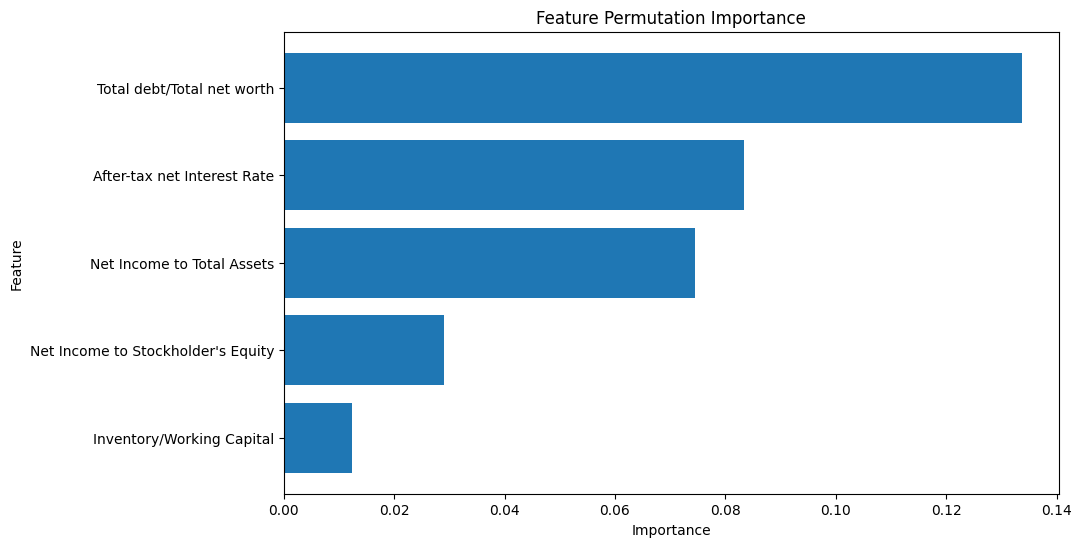

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  After-tax net Interest Rate
Original feat removed so far:  ['Total debt/Total net worth', 'After-tax net Interest Rate']

--- NEW ITERATION ---
Removing feature:  Net Income to Total Assets
Original feat removed so far:  ['Total debt/Total net worth', 'After-tax net Interest Rate', 'Net Income to Total Assets']

--- NEW ITERATION ---
Removing feature:  Net Income to Stockholder's Equity
Original feat removed so far:  ['Total debt/Total net worth', 'After-tax net Interest Rate', 'Net Income to Total Assets', "Net Income to Stockholder's Equity"]

--- NEW ITERATION ---
Removing feature:  Inventory/Working Capital
Original feat removed so far:  ['Total debt/Total net worth', 'After-tax net Interest Rate', 'Net Income to Total Assets', "Net Income to Stockholder's Equity", 'Inventory/Working Capital']

--- NEW ITERATION

In [ ]:
dt2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   32  1171  149  12      17.68   72.73        88.71     88.20     28.44   
1   17  1270   50  27      25.37   38.64        96.21     94.35     30.63   
2   17  1270   50  27      25.37   38.64        96.21     94.35     30.63   
3    4  1298   22  40      15.38    9.09        98.33     95.45     11.43   
4    4  1298   22  40      15.38    9.09        98.33     95.45     11.43   
5    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
6    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               80.72                 0   
1               67.42                 1   
2               67.42                 2   
3               53.71                 3   
4               53.71                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1              ['Total debt/Total net worth'] imputed  
2   ['Total debt/Total net worth', 'After-tax net ...  
3   ['Total debt/Total net worth', 'After-tax net ...  
4   ['Total debt/Total net worth', 'After-tax net ...  
5   ['Total debt/Total net worth', 'After-tax net ...  
6   ['Total debt/Total net worth', 'After-tax net ...  
7   ['Total debt/Total net worth', 'After-tax net ...  
8   ['Total debt/Total net worth', 'After-tax net ...  
9   ['Total debt/Total net worth', 'After-tax net ...  
10  ['Total debt/Total net worth', 'After-tax net ...  
11  ['Total debt/Total net worth', 'After-tax net ...  
12  ['Total debt/Total net worth', 'After-tax net ...  
13  ['Total debt/Total net worth', 'After-tax net ...  
14  ['Total debt/Total net worth', 'After-tax net ...  
15  ['Total debt/Total net worth', 'After-tax net ...  
16  ['Total debt/Total net worth', 'After-tax net ...  
17  ['Total debt/Total net worth', 'After-tax net ...  
18  ['Total debt/Total net worth', 'After-tax net ...  
19  ['Total debt/Total net worth', 'After-tax net ...  
20  ['Total debt/Total net worth', 'After-tax net ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:56:36.233262

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 

In [ ]:
dt2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   32  1171  149  12      17.68   72.73        88.71     88.20     28.44   
1   33  1151  169  11      16.34   75.00        87.20     86.80     26.83   
2   33  1149  171  11      16.18   75.00        87.05     86.66     26.61   
3   33  1157  163  11      16.84   75.00        87.65     87.24     27.50   
4   34  1163  157  10      17.80   77.27        88.11     87.76     28.94   
5   34  1143  177  10      16.11   77.27        86.59     86.29     26.67   
6   34  1142  178  10      16.04   77.27        86.52     86.22     26.56   
7   34  1147  173  10      16.43   77.27        86.89     86.58     27.09   
8   33  1146  174  11      15.94   75.00        86.82     86.44     26.29   
9   33  1149  171  11      16.18   75.00        87.05     86.66     26.61   
10  33  1148  172  11      16.10   75.00        86.97     86.58     26.51   
11  33  1155  165  11      16.67   75.00        87.50     87.10     27.27   
12  33  1158  162  11      16.92   75.00        87.73     87.32     27.62   
13  33  1159  161  11      17.01   75.00        87.80     87.39     27.73   
14  33  1158  162  11      16.92   75.00        87.73     87.32     27.62   
15  33  1160  160  11      17.10   75.00        87.88     87.46     27.85   
16  33  1152  168  11      16.42   75.00        87.27     86.88     26.94   
17  33  1153  167  11      16.50   75.00        87.35     86.95     27.05   
18  33  1165  155  11      17.55   75.00        88.26     87.83     28.45   
19  33  1168  152  11      17.84   75.00        88.48     88.05     28.82   
20  33  1167  153  11      17.74   75.00        88.41     87.98     28.70   

    balanced_accuracy  num_feat_missing  \
0               80.72                 0   
1               81.10                 1   
2               81.02                 2   
3               81.33                 3   
4               82.69                 4   
5               81.93                 5   
6               81.89                 6   
7               82.08                 7   
8               80.91                 8   
9               81.02                 9   
10              80.98                10   
11              81.25                11   
12              81.36                12   
13              81.40                13   
14              81.36                14   
15              81.44                15   
16              81.14                16   
17              81.17                17   
18              81.63                18   
19              81.74                19   
20              81.70                20   

                                              imputed  
0                                                      
1              ['Total debt/Total net worth'] imputed  
2   ['Total debt/Total net worth', 'After-tax net ...  
3   ['Total debt/Total net worth', 'After-tax net ...  
4   ['Total debt/Total net worth', 'After-tax net ...  
5   ['Total debt/Total net worth', 'After-tax net ...  
6   ['Total debt/Total net worth', 'After-tax net ...  
7   ['Total debt/Total net worth', 'After-tax net ...  
8   ['Total debt/Total net worth', 'After-tax net ...  
9   ['Total debt/Total net worth', 'After-tax net ...  
10  ['Total debt/Total net worth', 'After-tax net ...  
11  ['Total debt/Total net worth', 'After-tax net ...  
12  ['Total debt/Total net worth', 'After-tax net ...  
13  ['Total debt/Total net worth', 'After-tax net ...  
14  ['Total debt/Total net worth', 'After-tax net ...  
15  ['Total debt/Total net worth', 'After-tax net ...  
16  ['Total debt/Total net worth', 'After-tax net ...  
17  ['Total debt/Total net worth', 'After-tax net ...  
18  ['Total debt/Total net worth', 'After-tax net ...  
19  ['Total debt/Total net worth', 'After-tax net ...  
20  ['Total debt/Total net worth', 'After-tax net ...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  rf2_param_grid = {
    'n_estimators': [200],
    'max_features': ['sqrt'],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.005],
    'max_depth': [3],
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 12:06:18.167142

Nested Cross-validation Results:
Individual scores: [0.85000963 0.84835423 0.86773109]
Average nested CV score: 0.855 (+/- 0.018)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.005, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.855
2025-01-16 12:06:28.854944

Execution time: 0.18 minutes



```
Starting hyperparameter tuning at: 2025-01-15 23:12:25.700416

Nested Cross-validation Results:
Individual scores: [0.85592739 0.85403605 0.82375868]
Average nested CV score: 0.845 (+/- 0.029)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.005, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.855
2025-01-16 00:39:59.074042

Execution time: 87.56 minutes
```



In [ ]:
# rf2_grid_search.cv_results_

In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
56                            Cash/Total Assets    0.002860  0.000139
58                       Cash/Current Liability    0.002689  0.000046
13          Interest-bearing debt interest rate    0.002273  0.001039
8   Non-industry income and expenditure/revenue    0.002178  0.002120
53              Working Capital to Total Assets    0.002064  0.001185
..                                          ...         ...       ...
6                     Pre-tax net Interest Rate   -0.001193  0.000221
39                         Borrowing dependency   -0.001383  0.002195
9          Continuous interest rate (after tax)   -0.002273  0.001201
18      Persistent EPS in the Last Four Seasons   -0.002482  0.001275
7                   After-tax net Interest Rate   -0.002974  0.001162

[81 rows x 3 columns]

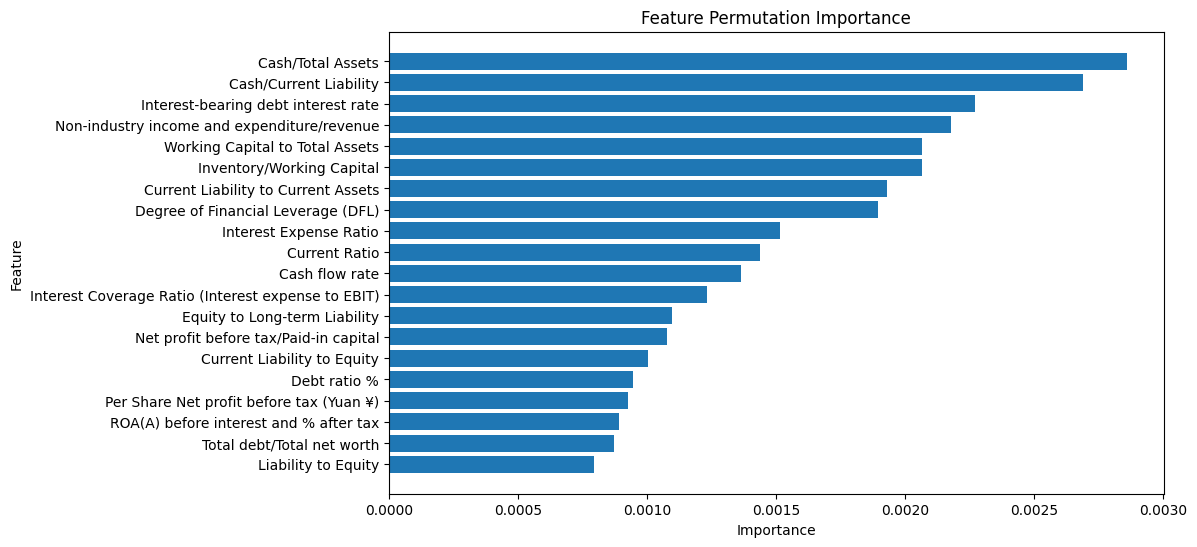

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Cash/Total Assets', 'Cash/Current Liability']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Cash/Total Assets', 'Cash/Current Liability', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Non-industry income and expenditure/revenue
Original feat removed so far:  ['Cash/Total Assets', 'Cash/Current Liability', 'Interest-bearing debt interest rate', 'Non-industry income and expenditure/revenue']

--- NEW ITERATION ---
Removing feature:  Working Capital to Total Assets
Original feat removed so far:  ['Cash/Total Assets', 'Cash/Current Liability', 'Interest-bearing debt interest rate', 'Non-industry income and expenditure/revenue', 'Working Capital to Total Assets']

--- NEW ITERATION ---

In [ ]:
rf2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1190  130   8      21.69   81.82        90.15     89.88     34.29   
1   36  1191  129   8      21.82   81.82        90.23     89.96     34.45   
2   35  1192  128   9      21.47   79.55        90.30     89.96     33.82   
3   34  1194  126  10      21.25   77.27        90.45     90.03     33.33   
4   34  1197  123  10      21.66   77.27        90.68     90.25     33.83   
5   34  1197  123  10      21.66   77.27        90.68     90.25     33.83   
6   34  1197  123  10      21.66   77.27        90.68     90.25     33.83   
7   34  1197  123  10      21.66   77.27        90.68     90.25     33.83   
8   34  1198  122  10      21.79   77.27        90.76     90.32     34.00   
9   34  1201  119  10      22.22   77.27        90.98     90.54     34.52   
10  34  1204  116  10      22.67   77.27        91.21     90.76     35.05   
11  34  1206  114  10      22.97   77.27        91.36     90.91     35.42   
12  34  1208  112  10      23.29   77.27        91.52     91.06     35.79   
13  34  1208  112  10      23.29   77.27        91.52     91.06     35.79   
14  34  1219  101  10      25.19   77.27        92.35     91.86     37.99   
15  34  1223   97  10      25.95   77.27        92.65     92.16     38.86   
16  34  1233   87  10      28.10   77.27        93.41     92.89     41.21   
17  34  1245   75  10      31.19   77.27        94.32     93.77     44.44   
18  31  1250   70  13      30.69   70.45        94.70     93.91     42.76   
19  28  1261   59  16      32.18   63.64        95.53     94.50     42.75   
20  25  1270   50  19      33.33   56.82        96.21     94.94     42.02   

    balanced_accuracy  num_feat_missing  \
0               85.98                 0   
1               86.02                 1   
2               84.92                 2   
3               83.86                 3   
4               83.98                 4   
5               83.98                 5   
6               83.98                 6   
7               83.98                 7   
8               84.02                 8   
9               84.13                 9   
10              84.24                10   
11              84.32                11   
12              84.39                12   
13              84.39                13   
14              84.81                14   
15              84.96                15   
16              85.34                16   
17              85.80                17   
18              82.58                18   
19              79.58                19   
20              76.52                20   

                                              imputed  
0                                                      
1                       ['Cash/Total Assets'] imputed  
2   ['Cash/Total Assets', 'Cash/Current Liability'...  
3   ['Cash/Total Assets', 'Cash/Current Liability'...  
4   ['Cash/Total Assets', 'Cash/Current Liability'...  
5   ['Cash/Total Assets', 'Cash/Current Liability'...  
6   ['Cash/Total Assets', 'Cash/Current Liability'...  
7   ['Cash/Total Assets', 'Cash/Current Liability'...  
8   ['Cash/Total Assets', 'Cash/Current Liability'...  
9   ['Cash/Total Assets', 'Cash/Current Liability'...  
10  ['Cash/Total Assets', 'Cash/Current Liability'...  
11  ['Cash/Total Assets', 'Cash/Current Liability'...  
12  ['Cash/Total Assets', 'Cash/Current Liability'...  
13  ['Cash/Total Assets', 'Cash/Current Liability'...  
14  ['Cash/Total Assets', 'Cash/Current Liability'...  
15  ['Cash/Total Assets', 'Cash/Current Liability'...  
16  ['Cash/Total Assets', 'Cash/Current Liability'...  
17  ['Cash/Total Assets', 'Cash/Current Liability'...  
18  ['Cash/Total Assets', 'Cash/Current Liability'...  
19  ['Cash/Total Assets', 'Cash/Current Liability'...  
20  ['Cash/Total Assets', 'Cash/Current Liability'...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 12:06:36.488179

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'After-ta

In [ ]:
rf2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1190  130   8      21.69   81.82        90.15     89.88     34.29   
1   36  1191  129   8      21.82   81.82        90.23     89.96     34.45   
2   35  1192  128   9      21.47   79.55        90.30     89.96     33.82   
3   35  1189  131   9      21.08   79.55        90.08     89.74     33.33   
4   35  1191  129   9      21.34   79.55        90.23     89.88     33.65   
5   35  1191  129   9      21.34   79.55        90.23     89.88     33.65   
6   35  1192  128   9      21.47   79.55        90.30     89.96     33.82   
7   35  1192  128   9      21.47   79.55        90.30     89.96     33.82   
8   35  1191  129   9      21.34   79.55        90.23     89.88     33.65   
9   35  1193  127   9      21.60   79.55        90.38     90.03     33.98   
10  35  1194  126   9      21.74   79.55        90.45     90.10     34.15   
11  35  1194  126   9      21.74   79.55        90.45     90.10     34.15   
12  35  1196  124   9      22.01   79.55        90.61     90.25     34.48   
13  35  1196  124   9      22.01   79.55        90.61     90.25     34.48   
14  35  1196  124   9      22.01   79.55        90.61     90.25     34.48   
15  35  1195  125   9      21.88   79.55        90.53     90.18     34.31   
16  35  1196  124   9      22.01   79.55        90.61     90.25     34.48   
17  34  1201  119  10      22.22   77.27        90.98     90.54     34.52   
18  34  1200  120  10      22.08   77.27        90.91     90.47     34.34   
19  34  1205  115  10      22.82   77.27        91.29     90.84     35.23   
20  34  1211  109  10      23.78   77.27        91.74     91.28     36.36   

    balanced_accuracy  num_feat_missing  \
0               85.98                 0   
1               86.02                 1   
2               84.92                 2   
3               84.81                 3   
4               84.89                 4   
5               84.89                 5   
6               84.92                 6   
7               84.92                 7   
8               84.89                 8   
9               84.96                 9   
10              85.00                10   
11              85.00                11   
12              85.08                12   
13              85.08                13   
14              85.08                14   
15              85.04                15   
16              85.08                16   
17              84.13                17   
18              84.09                18   
19              84.28                19   
20              84.51                20   

                                              imputed  
0                                                      
1                       ['Cash/Total Assets'] imputed  
2   ['Cash/Total Assets', 'Cash/Current Liability'...  
3   ['Cash/Total Assets', 'Cash/Current Liability'...  
4   ['Cash/Total Assets', 'Cash/Current Liability'...  
5   ['Cash/Total Assets', 'Cash/Current Liability'...  
6   ['Cash/Total Assets', 'Cash/Current Liability'...  
7   ['Cash/Total Assets', 'Cash/Current Liability'...  
8   ['Cash/Total Assets', 'Cash/Current Liability'...  
9   ['Cash/Total Assets', 'Cash/Current Liability'...  
10  ['Cash/Total Assets', 'Cash/Current Liability'...  
11  ['Cash/Total Assets', 'Cash/Current Liability'...  
12  ['Cash/Total Assets', 'Cash/Current Liability'...  
13  ['Cash/Total Assets', 'Cash/Current Liability'...  
14  ['Cash/Total Assets', 'Cash/Current Liability'...  
15  ['Cash/Total Assets', 'Cash/Current Liability'...  
16  ['Cash/Total Assets', 'Cash/Current Liability'...  
17  ['Cash/Total Assets', 'Cash/Current Liability'...  
18  ['Cash/Total Assets', 'Cash/Current Liability'...  
19  ['Cash/Total Assets', 'Cash/Current Liability'...  
20  ['Cash/Total Assets', 'Cash/Current Liability'...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [25, 15, 1],
      'min_split_gain': [1.0, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'min_child_samples': [25],
      'min_split_gain': [1.0],
      'reg_lambda': [10.0]
  }

gbt2_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 12:16:17.898434

Nested Cross-validation Results:
Individual scores: [0.8526146  0.82495102 0.82967499]
Average nested CV score: 0.836 (+/- 0.024)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 25, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.836
2025-01-16 12:16:23.089434

Execution time: 0.09 minutes


```
Starting hyperparameter tuning at: 2025-01-13 02:54:28.509241

Nested Cross-validation Results:
Individual scores: [0.87548151 0.79681622 0.84463437]
Average nested CV score: 0.839 (+/- 0.065)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 15, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.841

Train score: 0.957
Test score: 0.841
Train-test score difference: 0.115
2025-01-13 03:03:30.955758

Execution time: 9.04 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 14:39:05.218527

Nested Cross-validation Results:
Individual scores: [0.8526146  0.82495102 0.81187308]
Average nested CV score: 0.830 (+/- 0.034)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 25, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.836

Train score: 0.961
Test score: 0.836
Train-test score difference: 0.126
2025-01-15 14:49:18.208906

Execution time: 10.22 minutes
```



In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
85            Net Income to Total Assets    0.090090  0.006866
35            Total debt/Total net worth    0.046834  0.004647
13   Interest-bearing debt interest rate    0.018788  0.004819
33                           Quick Ratio    0.013938  0.002643
45          Accounts Receivable Turnover    0.011780  0.001343
..                                   ...         ...       ...
38  Long-term fund suitability ratio (A)   -0.000152  0.000046
19                   Cash Flow Per Share   -0.000246  0.000142
81                         CFO to Assets   -0.000284  0.000104
89    Net Income to Stockholder's Equity   -0.000474  0.000134
9   Continuous interest rate (after tax)   -0.000777  0.000174

[67 rows x 3 columns]

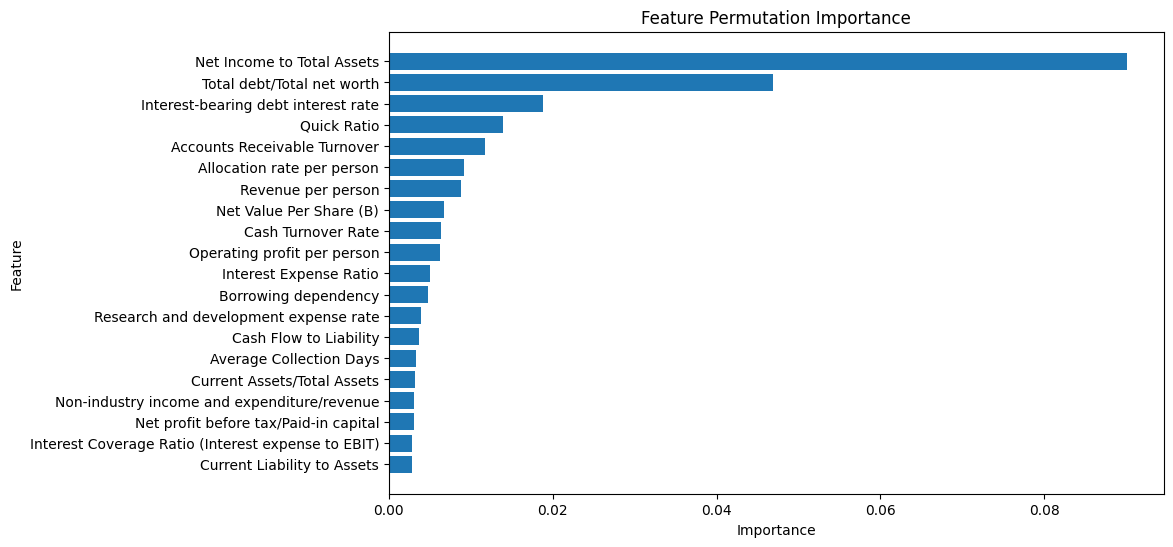

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Net Income to Total Assets
Original feat removed so far:  ['Net Income to Total Assets']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Net Income to Total Assets', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Net Income to Total Assets', 'Total debt/Total net worth', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Net Income to Total Assets', 'Total debt/Total net worth', 'Interest-bearing debt interest rate', 'Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Original feat removed so far:  ['Net Income to Total Assets', 'Total debt/Total net worth', 'Interest-bearing debt interest rate', 'Quick Ratio', 'Accounts Receivable Turnover']

--- NEW ITERATION ---
Removing feature:  Allocati

In [ ]:
gbt2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   35  1212  108   9      24.48   79.55        91.82     91.42     37.43   
1   15  1310   10  29      60.00   34.09        99.24     97.14     43.48   
2   14  1311    9  30      60.87   31.82        99.32     97.14     41.79   
3    9  1319    1  35      90.00   20.45        99.92     97.36     33.33   
4    6  1320    0  38     100.00   13.64       100.00     97.21     24.00   
5    4  1320    0  40     100.00    9.09       100.00     97.07     16.67   
6    3  1320    0  41     100.00    6.82       100.00     96.99     12.77   
7    2  1320    0  42     100.00    4.55       100.00     96.92      8.70   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               85.68                 0   
1               66.67                 1   
2               65.57                 2   
3               60.19                 3   
4               56.82                 4   
5               54.55                 5   
6               53.41                 6   
7               52.27                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1              ['Net Income to Total Assets'] imputed  
2   ['Net Income to Total Assets', 'Total debt/Tot...  
3   ['Net Income to Total Assets', 'Total debt/Tot...  
4   ['Net Income to Total Assets', 'Total debt/Tot...  
5   ['Net Income to Total Assets', 'Total debt/Tot...  
6   ['Net Income to Total Assets', 'Total debt/Tot...  
7   ['Net Income to Total Assets', 'Total debt/Tot...  
8   ['Net Income to Total Assets', 'Total debt/Tot...  
9   ['Net Income to Total Assets', 'Total debt/Tot...  
10  ['Net Income to Total Assets', 'Total debt/Tot...  
11  ['Net Income to Total Assets', 'Total debt/Tot...  
12  ['Net Income to Total Assets', 'Total debt/Tot...  
13  ['Net Income to Total Assets', 'Total debt/Tot...  
14  ['Net Income to Total Assets', 'Total debt/Tot...  
15  ['Net Income to Total Assets', 'Total debt/Tot...  
16  ['Net Income to Total Assets', 'Total debt/Tot...  
17  ['Net Income to Total Assets', 'Total debt/Tot...  
18  ['Net Income to Total Assets', 'Total debt/Tot...  
19  ['Net Income to Total Assets', 'Total debt/Tot...  
20  ['Net Income to Total Assets', 'Total debt/Tot...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 12:16:26.545168

--- NEW ITERATION ---
Removing feature:  Net Income to Total Assets
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 

In [ ]:
gbt2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   35  1212  108   9      24.48   79.55        91.82     91.42     37.43   
1   35  1212  108   9      24.48   79.55        91.82     91.42     37.43   
2   34  1204  116  10      22.67   77.27        91.21     90.76     35.05   
3   36  1183  137   8      20.81   81.82        89.62     89.37     33.18   
4   34  1208  112  10      23.29   77.27        91.52     91.06     35.79   
5   33  1215  105  11      23.91   75.00        92.05     91.50     36.26   
6   33  1209  111  11      22.92   75.00        91.59     91.06     35.11   
7   33  1207  113  11      22.60   75.00        91.44     90.91     34.74   
8   33  1211  109  11      23.24   75.00        91.74     91.20     35.48   
9   34  1209  111  10      23.45   77.27        91.59     91.13     35.98   
10  33  1208  112  11      22.76   75.00        91.52     90.98     34.92   
11  32  1206  114  12      21.92   72.73        91.36     90.76     33.68   
12  32  1204  116  12      21.62   72.73        91.21     90.62     33.33   
13  33  1205  115  11      22.30   75.00        91.29     90.76     34.38   
14  33  1207  113  11      22.60   75.00        91.44     90.91     34.74   
15  33  1206  114  11      22.45   75.00        91.36     90.84     34.55   
16  33  1207  113  11      22.60   75.00        91.44     90.91     34.74   
17  33  1210  110  11      23.08   75.00        91.67     91.13     35.29   
18  33  1218  102  11      24.44   75.00        92.27     91.72     36.87   
19  33  1217  103  11      24.26   75.00        92.20     91.64     36.67   
20  34  1219  101  10      25.19   77.27        92.35     91.86     37.99   

    balanced_accuracy  num_feat_missing  \
0               85.68                 0   
1               85.68                 1   
2               84.24                 2   
3               85.72                 3   
4               84.39                 4   
5               83.52                 5   
6               83.30                 6   
7               83.22                 7   
8               83.37                 8   
9               84.43                 9   
10              83.26                10   
11              82.05                11   
12              81.97                12   
13              83.14                13   
14              83.22                14   
15              83.18                15   
16              83.22                16   
17              83.33                17   
18              83.64                18   
19              83.60                19   
20              84.81                20   

                                              imputed  
0                                                      
1              ['Net Income to Total Assets'] imputed  
2   ['Net Income to Total Assets', 'Total debt/Tot...  
3   ['Net Income to Total Assets', 'Total debt/Tot...  
4   ['Net Income to Total Assets', 'Total debt/Tot...  
5   ['Net Income to Total Assets', 'Total debt/Tot...  
6   ['Net Income to Total Assets', 'Total debt/Tot...  
7   ['Net Income to Total Assets', 'Total debt/Tot...  
8   ['Net Income to Total Assets', 'Total debt/Tot...  
9   ['Net Income to Total Assets', 'Total debt/Tot...  
10  ['Net Income to Total Assets', 'Total debt/Tot...  
11  ['Net Income to Total Assets', 'Total debt/Tot...  
12  ['Net Income to Total Assets', 'Total debt/Tot...  
13  ['Net Income to Total Assets', 'Total debt/Tot...  
14  ['Net Income to Total Assets', 'Total debt/Tot...  
15  ['Net Income to Total Assets', 'Total debt/Tot...  
16  ['Net Income to Total Assets', 'Total debt/Tot...  
17  ['Net Income to Total Assets', 'Total debt/Tot...  
18  ['Net Income to Total Assets', 'Total debt/Tot...  
19  ['Net Income to Total Assets', 'Total debt/Tot...  
20  ['Net Income to Total Assets', 'Total debt/Tot...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # best model
  xgb2_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[10.0],
    'gamma': [1.0],
    'colsample_bytree':[0.25]
}

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE, n_jobs=1
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 12:26:06.433694

Nested Cross-validation Results:
Individual scores: [0.82586672 0.79794279 0.80634702]
Average nested CV score: 0.810 (+/- 0.023)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.810
2025-01-16 12:26:10.873382

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-13 02:23:36.833708

Nested Cross-validation Results:
Individual scores: [0.6409428  0.64456309 0.64037252]
Average nested CV score: 0.642 (+/- 0.004)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 300, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.667

Train score: 1.000
Test score: 0.667
Train-test score difference: 0.333
2025-01-13 02:45:25.416343

Execution time: 21.81 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 14:49:18.217919

Nested Cross-validation Results:
Individual scores: [0.82586672 0.79794279 0.78826086]
Average nested CV score: 0.804 (+/- 0.032)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.810

Train score: 0.985
Test score: 0.810
Train-test score difference: 0.175
2025-01-15 15:16:58.110655

Execution time: 27.66 minutes
```


In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
33                              Quick Ratio    0.029753  0.002450
13      Interest-bearing debt interest rate    0.003276  0.002238
45             Accounts Receivable Turnover    0.002481  0.000163
51              Operating profit per person    0.001970  0.000627
46                  Average Collection Days    0.001913  0.000573
..                                      ...         ...       ...
68               Total income/Total expense   -0.002917  0.000346
39                     Borrowing dependency   -0.003637  0.000342
93                      Equity to Liability   -0.003675  0.000351
35               Total debt/Total net worth   -0.003845  0.000326
18  Persistent EPS in the Last Four Seasons   -0.004906  0.000477

[84 rows x 3 columns]

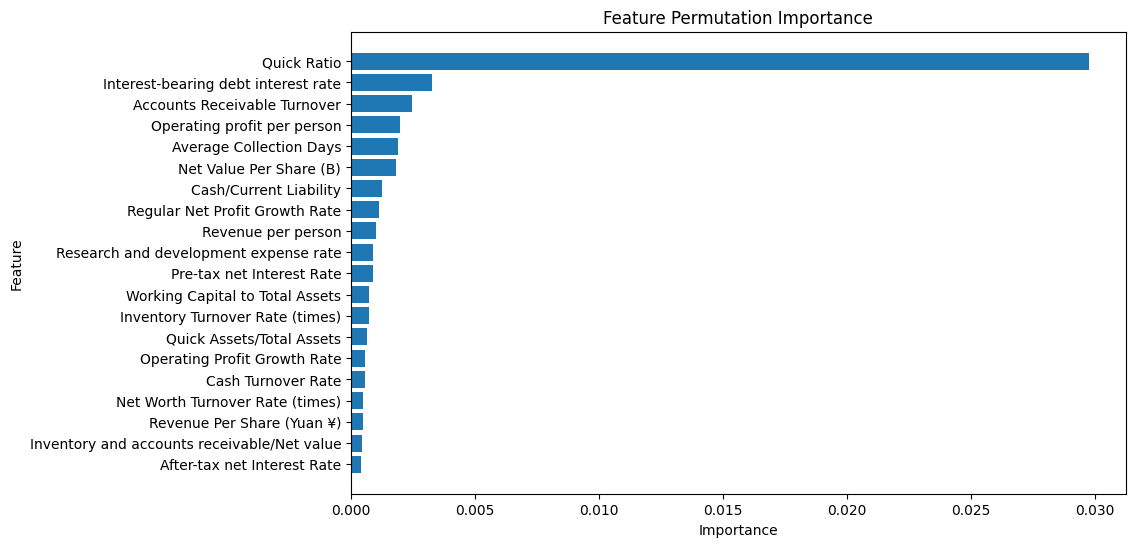

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Quick Ratio', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Original feat removed so far:  ['Quick Ratio', 'Interest-bearing debt interest rate', 'Accounts Receivable Turnover']

--- NEW ITERATION ---
Removing feature:  Operating profit per person
Original feat removed so far:  ['Quick Ratio', 'Interest-bearing debt interest rate', 'Accounts Receivable Turnover', 'Operating profit per person']

--- NEW ITERATION ---
Removing feature:  Average Collection Days
Original feat removed so far:  ['Quick Ratio', 'Interest-bearing debt interest rate', 'Accounts Receivable Turnover', 'Operating profit per person', 'Average Collection Days']

--- NEW ITERATION ---
Removing feature:  Net Value Per Share (B)
Original feat remov

In [ ]:
xgb2_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   30  1264  56  14      34.88   68.18        95.76     94.87     46.15   
1   25  1293  27  19      48.08   56.82        97.95     96.63     52.08   
2   17  1306  14  27      54.84   38.64        98.94     96.99     45.33   
3   15  1308  12  29      55.56   34.09        99.09     96.99     42.25   
4   15  1306  14  29      51.72   34.09        98.94     96.85     41.10   
5   12  1307  13  32      48.00   27.27        99.02     96.70     34.78   
6   13  1309  11  31      54.17   29.55        99.17     96.92     38.24   
7   19  1303  17  25      52.78   43.18        98.71     96.92     47.50   
8   19  1301  19  25      50.00   43.18        98.56     96.77     46.34   
9   18  1303  17  26      51.43   40.91        98.71     96.85     45.57   
10  19  1300  20  25      48.72   43.18        98.48     96.70     45.78   
11  20  1300  20  24      50.00   45.45        98.48     96.77     47.62   
12  22  1300  20  22      52.38   50.00        98.48     96.92     51.16   
13  17  1303  17  27      50.00   38.64        98.71     96.77     43.59   
14  19  1301  19  25      50.00   43.18        98.56     96.77     46.34   
15  19  1299  21  25      47.50   43.18        98.41     96.63     45.24   
16  21  1299  21  23      50.00   47.73        98.41     96.77     48.84   
17  20  1301  19  24      51.28   45.45        98.56     96.85     48.19   
18  20  1301  19  24      51.28   45.45        98.56     96.85     48.19   
19  18  1301  19  26      48.65   40.91        98.56     96.70     44.44   
20  19  1299  21  25      47.50   43.18        98.41     96.63     45.24   

    balanced_accuracy  num_feat_missing  \
0               81.97                 0   
1               77.39                 1   
2               68.79                 2   
3               66.59                 3   
4               66.52                 4   
5               63.14                 5   
6               64.36                 6   
7               70.95                 7   
8               70.87                 8   
9               69.81                 9   
10              70.83                10   
11              71.97                11   
12              74.24                12   
13              68.67                13   
14              70.87                14   
15              70.80                15   
16              73.07                16   
17              72.01                17   
18              72.01                18   
19              69.73                19   
20              70.80                20   

                                              imputed  
0                                                      
1                             ['Quick Ratio'] imputed  
2   ['Quick Ratio', 'Interest-bearing debt interes...  
3   ['Quick Ratio', 'Interest-bearing debt interes...  
4   ['Quick Ratio', 'Interest-bearing debt interes...  
5   ['Quick Ratio', 'Interest-bearing debt interes...  
6   ['Quick Ratio', 'Interest-bearing debt interes...  
7   ['Quick Ratio', 'Interest-bearing debt interes...  
8   ['Quick Ratio', 'Interest-bearing debt interes...  
9   ['Quick Ratio', 'Interest-bearing debt interes...  
10  ['Quick Ratio', 'Interest-bearing debt interes...  
11  ['Quick Ratio', 'Interest-bearing debt interes...  
12  ['Quick Ratio', 'Interest-bearing debt interes...  
13  ['Quick Ratio', 'Interest-bearing debt interes...  
14  ['Quick Ratio', 'Interest-bearing debt interes...  
15  ['Quick Ratio', 'Interest-bearing debt interes...  
16  ['Quick Ratio', 'Interest-bearing debt interes...  
17  ['Quick Ratio', 'Interest-bearing debt interes...  
18  ['Quick Ratio', 'Interest-bearing debt interes...  
19  ['Quick Ratio', 'Interest-bearing debt interes...  
20  ['Quick Ratio', 'Interest-bearing debt interes...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 12:26:14.911377

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'After-tax Net 

In [ ]:
xgb2_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   30  1264  56  14      34.88   68.18        95.76     94.87     46.15   
1   25  1285  35  19      41.67   56.82        97.35     96.04     48.08   
2   27  1272  48  17      36.00   61.36        96.36     95.23     45.38   
3   26  1280  40  18      39.39   59.09        96.97     95.75     47.27   
4   26  1279  41  18      38.81   59.09        96.89     95.67     46.85   
5   26  1281  39  18      40.00   59.09        97.05     95.82     47.71   
6   27  1285  35  17      43.55   61.36        97.35     96.19     50.94   
7   28  1273  47  16      37.33   63.64        96.44     95.38     47.06   
8   28  1275  45  16      38.36   63.64        96.59     95.53     47.86   
9   29  1269  51  15      36.25   65.91        96.14     95.16     46.77   
10  30  1263  57  14      34.48   68.18        95.68     94.79     45.80   
11  30  1263  57  14      34.48   68.18        95.68     94.79     45.80   
12  30  1268  52  14      36.59   68.18        96.06     95.16     47.62   
13  31  1268  52  13      37.35   70.45        96.06     95.23     48.82   
14  28  1271  49  16      36.36   63.64        96.29     95.23     46.28   
15  28  1272  48  16      36.84   63.64        96.36     95.31     46.67   
16  27  1276  44  17      38.03   61.36        96.67     95.53     46.96   
17  27  1279  41  17      39.71   61.36        96.89     95.75     48.21   
18  27  1278  42  17      39.13   61.36        96.82     95.67     47.79   
19  27  1278  42  17      39.13   61.36        96.82     95.67     47.79   
20  28  1279  41  16      40.58   63.64        96.89     95.82     49.56   

    balanced_accuracy  num_feat_missing  \
0               81.97                 0   
1               77.08                 1   
2               78.86                 2   
3               78.03                 3   
4               77.99                 4   
5               78.07                 5   
6               79.36                 6   
7               80.04                 7   
8               80.11                 8   
9               81.02                 9   
10              81.93                10   
11              81.93                11   
12              82.12                12   
13              83.26                13   
14              79.96                14   
15              80.00                15   
16              79.02                16   
17              79.13                17   
18              79.09                18   
19              79.09                19   
20              80.27                20   

                                              imputed  
0                                                      
1                             ['Quick Ratio'] imputed  
2   ['Quick Ratio', 'Interest-bearing debt interes...  
3   ['Quick Ratio', 'Interest-bearing debt interes...  
4   ['Quick Ratio', 'Interest-bearing debt interes...  
5   ['Quick Ratio', 'Interest-bearing debt interes...  
6   ['Quick Ratio', 'Interest-bearing debt interes...  
7   ['Quick Ratio', 'Interest-bearing debt interes...  
8   ['Quick Ratio', 'Interest-bearing debt interes...  
9   ['Quick Ratio', 'Interest-bearing debt interes...  
10  ['Quick Ratio', 'Interest-bearing debt interes...  
11  ['Quick Ratio', 'Interest-bearing debt interes...  
12  ['Quick Ratio', 'Interest-bearing debt interes...  
13  ['Quick Ratio', 'Interest-bearing debt interes...  
14  ['Quick Ratio', 'Interest-bearing debt interes...  
15  ['Quick Ratio', 'Interest-bearing debt interes...  
16  ['Quick Ratio', 'Interest-bearing debt interes...  
17  ['Quick Ratio', 'Interest-bearing debt interes...  
18  ['Quick Ratio', 'Interest-bearing debt interes...  
19  ['Quick Ratio', 'Interest-bearing debt interes...  
20  ['Quick Ratio', 'Interest-bearing debt interes...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et2_param_grid = {
      'n_estimators': [200],
      'max_depth': [5],
      'max_features':['sqrt'],
      'min_samples_split': [2],
      'min_samples_leaf': [1]
  }

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 12:36:02.360026

Nested Cross-validation Results:
Individual scores: [0.86549018 0.83841105 0.91374625]
Average nested CV score: 0.873 (+/- 0.062)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.873
2025-01-16 12:36:08.391291

Execution time: 0.10 minutes




```
Starting hyperparameter tuning at: 2025-01-15 15:16:58.122628

Nested Cross-validation Results:
Individual scores: [0.85469472 0.82562696 0.91061948]
Average nested CV score: 0.864 (+/- 0.071)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.873

Train score: 0.890
Test score: 0.873
Train-test score difference: 0.018
2025-01-15 15:41:07.456398

Execution time: 24.16 minutes
```



In [ ]:
# et2_grid_search.cv_results_

In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
37                                   Net worth/Assets    0.007859  0.005101
36                                       Debt ratio %    0.004810  0.002755
10                             Operating Expense Rate    0.002159  0.001349
35                         Total debt/Total net worth    0.002083  0.001238
54                          Quick Assets/Total Assets    0.001837  0.002183
..                                                ...         ...       ...
17                            Net Value Per Share (C)   -0.003788  0.001249
2   ROA(B) before interest and depreciation after tax   -0.004584  0.003286
1              ROA(A) before interest and % after tax   -0.004812  0.003233
14                                       Tax rate (A)   -0.004982  0.003583
0   ROA(C) before interest and depreciation before...   -0.005266  0.003846

[89 rows x 3 columns]

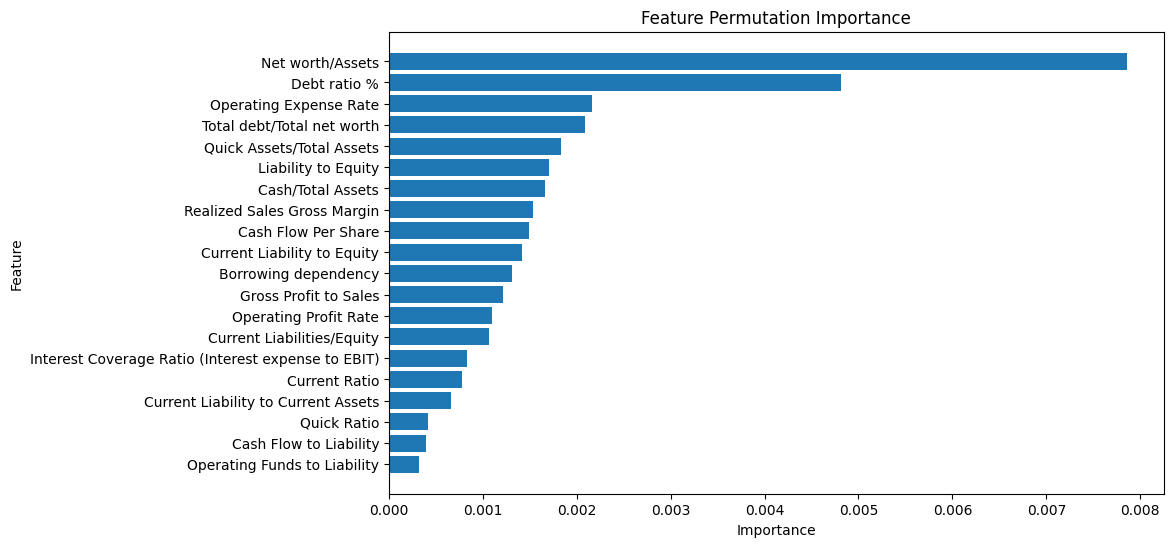

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Net worth/Assets
Original feat removed so far:  ['Net worth/Assets']

--- NEW ITERATION ---
Removing feature:  Debt ratio %
Original feat removed so far:  ['Net worth/Assets', 'Debt ratio %']

--- NEW ITERATION ---
Removing feature:  Operating Expense Rate
Original feat removed so far:  ['Net worth/Assets', 'Debt ratio %', 'Operating Expense Rate']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Net worth/Assets', 'Debt ratio %', 'Operating Expense Rate', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Original feat removed so far:  ['Net worth/Assets', 'Debt ratio %', 'Operating Expense Rate', 'Total debt/Total net worth', 'Quick Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Liability to Equity
Original feat removed so far:  ['Net worth/Assets', 'Debt ratio %', 'Operating Expense Rate', 'Total debt/Total net worth', 'Quick 

In [ ]:
et2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1165  155   8      18.85   81.82        88.26     88.05     30.64   
1   35  1188  132   9      20.96   79.55        90.00     89.66     33.18   
2   33  1193  127  11      20.62   75.00        90.38     89.88     32.35   
3   33  1192  128  11      20.50   75.00        90.30     89.81     32.20   
4   33  1193  127  11      20.62   75.00        90.38     89.88     32.35   
5   32  1206  114  12      21.92   72.73        91.36     90.76     33.68   
6   32  1210  110  12      22.54   72.73        91.67     91.06     34.41   
7   32  1201  119  12      21.19   72.73        90.98     90.40     32.82   
8   32  1201  119  12      21.19   72.73        90.98     90.40     32.82   
9   32  1203  117  12      21.48   72.73        91.14     90.54     33.16   
10  32  1206  114  12      21.92   72.73        91.36     90.76     33.68   
11  28  1215  105  16      21.05   63.64        92.05     91.13     31.64   
12  27  1220  100  17      21.26   61.36        92.42     91.42     31.58   
13  26  1219  101  18      20.47   59.09        92.35     91.28     30.41   
14  25  1225   95  19      20.83   56.82        92.80     91.64     30.49   
15  25  1225   95  19      20.83   56.82        92.80     91.64     30.49   
16  25  1229   91  19      21.55   56.82        93.11     91.94     31.25   
17  25  1233   87  19      22.32   56.82        93.41     92.23     32.05   
18  25  1233   87  19      22.32   56.82        93.41     92.23     32.05   
19  25  1233   87  19      22.32   56.82        93.41     92.23     32.05   
20  25  1234   86  19      22.52   56.82        93.48     92.30     32.26   

    balanced_accuracy  num_feat_missing  \
0               85.04                 0   
1               84.77                 1   
2               82.69                 2   
3               82.65                 3   
4               82.69                 4   
5               82.05                 5   
6               82.20                 6   
7               81.86                 7   
8               81.86                 8   
9               81.93                 9   
10              82.05                10   
11              77.84                11   
12              76.89                12   
13              75.72                13   
14              74.81                14   
15              74.81                15   
16              74.96                16   
17              75.11                17   
18              75.11                18   
19              75.11                19   
20              75.15                20   

                                              imputed  
0                                                      
1                        ['Net worth/Assets'] imputed  
2        ['Net worth/Assets', 'Debt ratio %'] imputed  
3   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
4   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
5   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
6   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
7   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
8   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
9   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
10  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
11  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
12  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
13  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
14  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
15  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
16  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
17  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
18  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
19  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
20  ['Net worth/Assets', 'Debt ratio %', 'Operatin...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 12:36:14.215846

--- NEW ITERATION ---
Removing feature:  Net worth/Assets
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'After-tax

In [ ]:
et2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1165  155   8      18.85   81.82        88.26     88.05     30.64   
1   36  1164  156   8      18.75   81.82        88.18     87.98     30.51   
2   36  1166  154   8      18.95   81.82        88.33     88.12     30.77   
3   36  1168  152   8      19.15   81.82        88.48     88.27     31.03   
4   36  1169  151   8      19.25   81.82        88.56     88.34     31.17   
5   36  1171  149   8      19.46   81.82        88.71     88.49     31.44   
6   36  1175  145   8      19.89   81.82        89.02     88.78     32.00   
7   36  1176  144   8      20.00   81.82        89.09     88.86     32.14   
8   36  1175  145   8      19.89   81.82        89.02     88.78     32.00   
9   36  1174  146   8      19.78   81.82        88.94     88.71     31.86   
10  36  1176  144   8      20.00   81.82        89.09     88.86     32.14   
11  35  1178  142   9      19.77   79.55        89.24     88.93     31.67   
12  35  1178  142   9      19.77   79.55        89.24     88.93     31.67   
13  35  1179  141   9      19.89   79.55        89.32     89.00     31.82   
14  34  1189  131  10      20.61   77.27        90.08     89.66     32.54   
15  34  1191  129  10      20.86   77.27        90.23     89.81     32.85   
16  33  1195  125  11      20.89   75.00        90.53     90.03     32.67   
17  33  1196  124  11      21.02   75.00        90.61     90.10     32.84   
18  33  1198  122  11      21.29   75.00        90.76     90.25     33.17   
19  33  1198  122  11      21.29   75.00        90.76     90.25     33.17   
20  33  1198  122  11      21.29   75.00        90.76     90.25     33.17   

    balanced_accuracy  num_feat_missing  \
0               85.04                 0   
1               85.00                 1   
2               85.08                 2   
3               85.15                 3   
4               85.19                 4   
5               85.27                 5   
6               85.42                 6   
7               85.45                 7   
8               85.42                 8   
9               85.38                 9   
10              85.45                10   
11              84.39                11   
12              84.39                12   
13              84.43                13   
14              83.67                14   
15              83.75                15   
16              82.77                16   
17              82.80                17   
18              82.88                18   
19              82.88                19   
20              82.88                20   

                                              imputed  
0                                                      
1                        ['Net worth/Assets'] imputed  
2        ['Net worth/Assets', 'Debt ratio %'] imputed  
3   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
4   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
5   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
6   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
7   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
8   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
9   ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
10  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
11  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
12  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
13  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
14  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
15  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
16  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
17  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
18  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
19  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  
20  ['Net worth/Assets', 'Debt ratio %', 'Operatin...

##**Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm2_param_grid = {
    'C': [2.0],
    'kernel': ['linear'],
    'gamma': ['scale'],
    'degree': [2]
}

svm2_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 3, 3, 'balanced_accuracy', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-16 12:45:55.463636

Nested Cross-validation Results:
Individual scores: [0.83968606 0.80374216 0.88116322]
Average nested CV score: 0.842 (+/- 0.063)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 2.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.842
2025-01-16 12:46:00.751004

Execution time: 0.09 minutes




```
Starting hyperparameter tuning at: 2025-01-15 15:41:07.466156

Nested Cross-validation Results:
Individual scores: [0.8552629  0.77418691 0.87325715]
Average nested CV score: 0.834 (+/- 0.086)

Fitting final model on entire dataset...
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best parameters: {'C': 2, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.842

Train score: 0.879
Test score: 0.842
Train-test score difference: 0.037
2025-01-15 15:46:58.713207

Execution time: 5.85 minutes
```



In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(svm2_classifier, X_train_scaled, y_train, scoring_metric="balanced_accuracy")
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
36                           Debt ratio %    0.026778  0.006455
37                       Net worth/Assets    0.026778  0.006455
56                      Cash/Total Assets    0.022404  0.003364
73                     Cash Turnover Rate    0.009697  0.001757
53        Working Capital to Total Assets    0.006912  0.004657
..                                    ...         ...       ...
93                    Equity to Liability   -0.001022  0.002114
68             Total income/Total expense   -0.001023  0.001235
63          Current Liabilities/Liability   -0.001098  0.002509
76         Current Liability to Liability   -0.001098  0.002509
11  Research and development expense rate   -0.001401  0.002109

[78 rows x 3 columns]

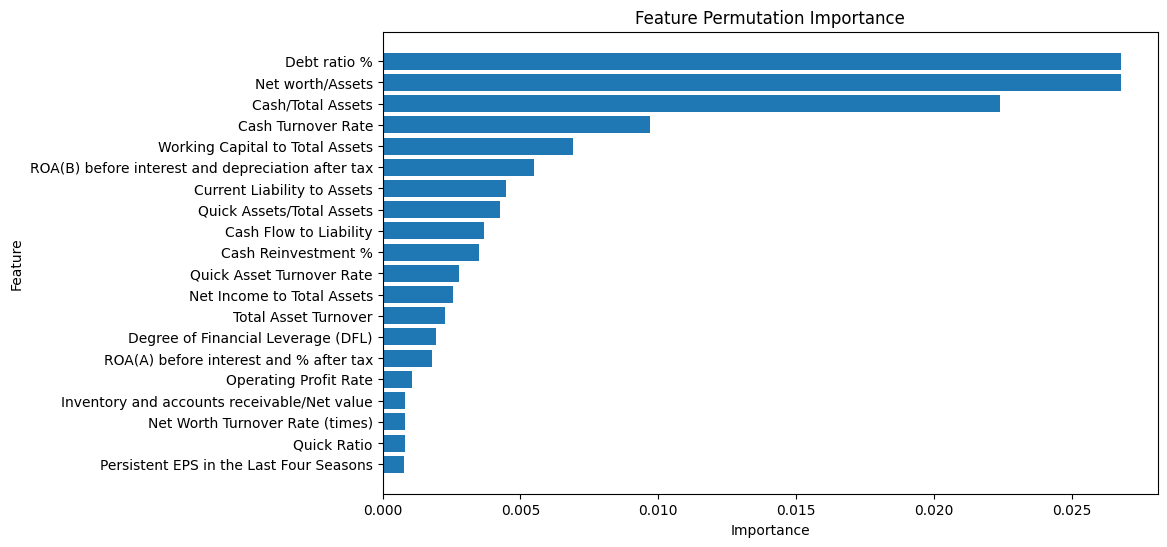

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    taiwan_imputation_scaled_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Debt ratio %
Original feat removed so far:  ['Debt ratio %']

--- NEW ITERATION ---
Removing feature:  Net worth/Assets
Original feat removed so far:  ['Debt ratio %', 'Net worth/Assets']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Debt ratio %', 'Net worth/Assets', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Debt ratio %', 'Net worth/Assets', 'Cash/Total Assets', 'Cash Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Working Capital to Total Assets
Original feat removed so far:  ['Debt ratio %', 'Net worth/Assets', 'Cash/Total Assets', 'Cash Turnover Rate', 'Working Capital to Total Assets']

--- NEW ITERATION ---
Removing feature:  ROA(B) before interest and depreciation after tax
Original feat removed so far:  ['Debt ratio %', 'Net worth/Assets', 'Cash/Total Assets', 'Cash Turnover Rate', 'Working Capital to Total 

In [ ]:
svm2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  1161  159   5      19.70   88.64        87.95     87.98     32.23   
1   33  1204  116  11      22.15   75.00        91.21     90.69     34.20   
2   24  1226   94  20      20.34   54.55        92.88     91.64     29.63   
3   22  1211  109  22      16.79   50.00        91.74     90.40     25.14   
4   25  1201  119  19      17.36   56.82        90.98     89.88     26.60   
5   23  1213  107  21      17.69   52.27        91.89     90.62     26.44   
6   21  1256   64  23      24.71   47.73        95.15     93.62     32.56   
7   16  1253   67  28      19.28   36.36        94.92     93.04     25.20   
8   17  1246   74  27      18.68   38.64        94.39     92.60     25.19   
9   16  1243   77  28      17.20   36.36        94.17     92.30     23.36   
10  17  1240   80  27      17.53   38.64        93.94     92.16     24.11   
11  19  1235   85  25      18.27   43.18        93.56     91.94     25.68   
12  14  1266   54  30      20.59   31.82        95.91     93.84     25.00   
13  12  1275   45  32      21.05   27.27        96.59     94.35     23.76   
14  12  1277   43  32      21.82   27.27        96.74     94.50     24.24   
15   6  1309   11  38      35.29   13.64        99.17     96.41     19.67   
16   6  1306   14  38      30.00   13.64        98.94     96.19     18.75   
17   7  1306   14  37      33.33   15.91        98.94     96.26     21.54   
18   8  1308   12  36      40.00   18.18        99.09     96.48     25.00   
19   8  1308   12  36      40.00   18.18        99.09     96.48     25.00   
20   4  1311    9  40      30.77    9.09        99.32     96.41     14.04   

    balanced_accuracy  num_feat_missing  \
0               88.30                 0   
1               83.11                 1   
2               73.71                 2   
3               70.87                 3   
4               73.90                 4   
5               72.08                 5   
6               71.44                 6   
7               65.64                 7   
8               66.52                 8   
9               65.27                 9   
10              66.29                10   
11              68.37                11   
12              63.86                12   
13              61.93                13   
14              62.01                14   
15              56.40                15   
16              56.29                16   
17              57.42                17   
18              58.64                18   
19              58.64                19   
20              54.20                20   

                                              imputed  
0                                                      
1                            ['Debt ratio %'] imputed  
2        ['Debt ratio %', 'Net worth/Assets'] imputed  
3   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
4   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
5   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
6   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
7   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
8   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
9   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
10  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
11  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
12  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
13  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
14  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
15  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
16  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
17  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
18  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
19  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
20  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 12:46:35.360700

--- NEW ITERATION ---
Removing feature:  Debt ratio %
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'After-tax Net

In [ ]:
svm2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  1161  159   5      19.70   88.64        87.95     87.98     32.23   
1   38  1162  158   6      19.39   86.36        88.03     87.98     31.67   
2   36  1173  147   8      19.67   81.82        88.86     88.64     31.72   
3   36  1177  143   8      20.11   81.82        89.17     88.93     32.29   
4   35  1177  143   9      19.66   79.55        89.17     88.86     31.53   
5   35  1177  143   9      19.66   79.55        89.17     88.86     31.53   
6   35  1178  142   9      19.77   79.55        89.24     88.93     31.67   
7   35  1183  137   9      20.35   79.55        89.62     89.30     32.41   
8   35  1183  137   9      20.35   79.55        89.62     89.30     32.41   
9   35  1188  132   9      20.96   79.55        90.00     89.66     33.18   
10  35  1184  136   9      20.47   79.55        89.70     89.37     32.56   
11  36  1192  128   8      21.95   81.82        90.30     90.03     34.62   
12  36  1196  124   8      22.50   81.82        90.61     90.32     35.29   
13  35  1200  120   9      22.58   79.55        90.91     90.54     35.18   
14  35  1202  118   9      22.88   79.55        91.06     90.69     35.53   
15  35  1209  111   9      23.97   79.55        91.59     91.20     36.84   
16  35  1208  112   9      23.81   79.55        91.52     91.13     36.65   
17  35  1207  113   9      23.65   79.55        91.44     91.06     36.46   
18  35  1209  111   9      23.97   79.55        91.59     91.20     36.84   
19  35  1209  111   9      23.97   79.55        91.59     91.20     36.84   
20  34  1219  101  10      25.19   77.27        92.35     91.86     37.99   

    balanced_accuracy  num_feat_missing  \
0               88.30                 0   
1               87.20                 1   
2               85.34                 2   
3               85.49                 3   
4               84.36                 4   
5               84.36                 5   
6               84.39                 6   
7               84.58                 7   
8               84.58                 8   
9               84.77                 9   
10              84.62                10   
11              86.06                11   
12              86.21                12   
13              85.23                13   
14              85.30                14   
15              85.57                15   
16              85.53                16   
17              85.49                17   
18              85.57                18   
19              85.57                19   
20              84.81                20   

                                              imputed  
0                                                      
1                            ['Debt ratio %'] imputed  
2        ['Debt ratio %', 'Net worth/Assets'] imputed  
3   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
4   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
5   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
6   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
7   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
8   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
9   ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
10  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
11  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
12  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
13  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
14  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
15  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
16  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
17  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
18  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
19  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...  
20  ['Debt ratio %', 'Net worth/Assets', 'Cash/Tot...

##**Logistic Regression**

In [ ]:
len(lr_X_test.columns)

64

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr2_param_grid = {
      'C': [5.0],
      'penalty': ['l1'],
      'solver': ['liblinear']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 3, 3, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 12:55:07.523019

Nested Cross-validation Results:
Individual scores: [0.83916602 0.77067986 0.85573949]
Average nested CV score: 0.822 (+/- 0.074)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.822
2025-01-16 12:55:54.267626

Execution time: 0.78 minutes




```
Starting hyperparameter tuning at: 2025-01-15 15:46:58.731582

Nested Cross-validation Results:
Individual scores: [0.82250096 0.75978644 0.85573949]
Average nested CV score: 0.813 (+/- 0.080)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.822

Train score: 0.878
Test score: 0.822
Train-test score difference: 0.057
2025-01-15 15:49:13.027600

Execution time: 2.24 minutes
```



In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
13                                Equity to Liability  9.397592e-02  0.008326
6                          Total income/Total expense  7.283792e-02  0.012036
24                                  Cash/Total Assets  3.535804e-02  0.006914
1                                Borrowing dependency  2.552890e-02  0.004179
32                             Cash Flow to Liability  1.859867e-02  0.011347
2                   Retained Earnings to Total Assets  9.033111e-03  0.006624
19                               Total expense/Assets  7.973919e-03  0.004448
15                              Liability-Assets Flag  6.193279e-03  0.000046
31                          Quick Assets/Total Assets  5.379484e-03  0.004275
7                             Net Value Per Share (A)  5.226326e-03  0.004518
52                     Current Liability to Liability  4.887182e-03  0.004194
56                    Inventory Turnover Rate (times)  4.583771e-03  0.007213
42               Long-term fund suitability ratio (A)  3.466027e-03  0.000142
9                 Operating Profit Per Share (Yuan ¥)  3.200503e-03  0.003051
36                    Fixed Assets Turnover Frequency  3.067902e-03  0.003560
50                          Quick Asset Turnover Rate  2.537929e-03  0.004066
55                             Operating Expense Rate  2.310721e-03  0.001539
30                 Degree of Financial Leverage (DFL)  2.121183e-03  0.001067
51                         Total debt/Total net worth  1.969747e-03  0.001417
4                 Current Liability to Current Assets  1.533951e-03  0.002066
53                Interest-bearing debt interest rate  1.268857e-03  0.001436
26                                Cash Flow to Equity  1.174680e-03  0.004299
46                                 Cash Turnover Rate  1.023244e-03  0.005849
60                       Accounts Receivable Turnover  1.003870e-03  0.001208
54                        Current Asset Turnover Rate  1.003763e-03  0.001359
25                   After-tax Net Profit Growth Rate  6.251184e-04  0.000097
14                                       Tax rate (A)  6.250108e-04  0.003340
61                            Average Collection Days  6.250108e-04  0.001109
48                          Total assets to GNP price  6.060678e-04  0.001118
29                                 No-credit Interval  3.220307e-04  0.000195
23        Inventory and accounts receivable/Net value  2.466893e-04  0.002380
62                     Quick Assets/Current Liability  5.682894e-05  0.000046
37                       Operating Profit Growth Rate  3.788596e-05  0.000046
59              Long-term Liability to Current Assets  1.894298e-05  0.000093
47              Research and development expense rate  2.152612e-07  0.002837
17                             Interest Expense Ratio -3.788596e-05  0.000076
45            Realized Sales Gross Profit Growth Rate -3.788596e-05  0.000097
57                         Allocation rate per person -3.788596e-05  0.000097
58                        Inventory/Current Liability -5.682894e-05  0.000046
18  Interest Coverage Ratio (Interest expense to E... -7.577193e-05  0.000038
28                             Cash/Current Liability -2.083728e-04  0.000071
11                        Operating profit per person -1.117528e-03  0.001219
39                            Total Asset Growth Rate -1.136364e-03  0.001135
16                             Operating Gross Margin -1.420616e-03  0.002885
35                               Total Asset Turnover -1.458287e-03  0.007895

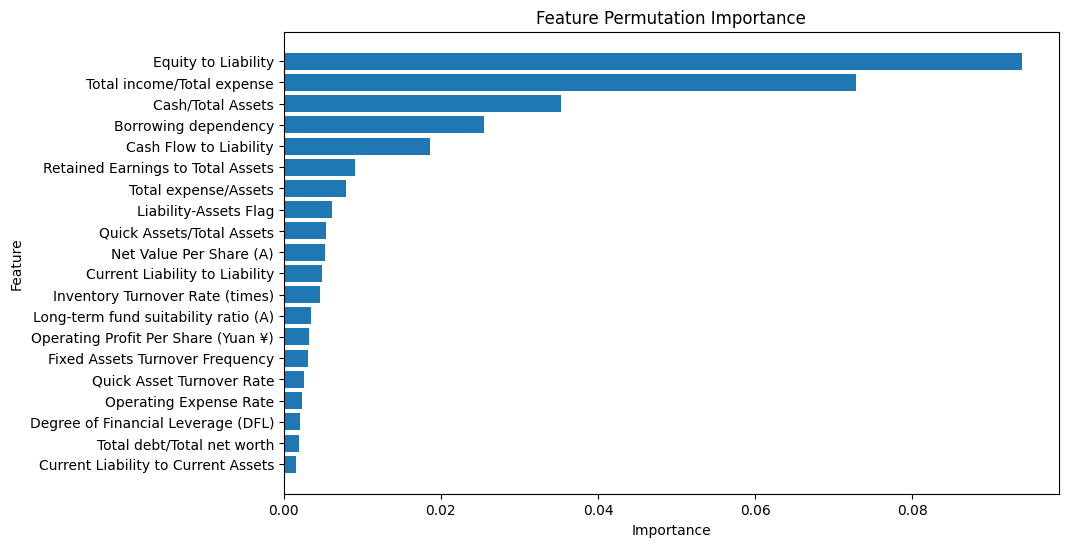

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Total income/Total expense
Original feat removed so far:  ['Equity to Liability', 'Total income/Total expense']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Equity to Liability', 'Total income/Total expense', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Equity to Liability', 'Total income/Total expense', 'Cash/Total Assets', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Liability
Original feat removed so far:  ['Equity to Liability', 'Total income/Total expense', 'Cash/Total Assets', 'Borrowing dependency', 'Cash Flow to Liability']

--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Original feat removed so far:  ['Equity to Liability', 'Total income/Tota

In [ ]:
lr2_perf

tp    tn    fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1160   160   8      18.37   81.82        87.88     87.68     30.00   
1   34  1169   151  10      18.38   77.27        88.56     88.20     29.69   
2   44    12  1308   0       3.25  100.00         0.91      4.11      6.30   
3   44     4  1316   0       3.24  100.00         0.30      3.52      6.27   
4   44     4  1316   0       3.24  100.00         0.30      3.52      6.27   
5   44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
6   44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
7   44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
8   44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
9   44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
10  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
11  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
12  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
13  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
14  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
15  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
16  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
17  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
18  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
19  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
20  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   

    balanced_accuracy  num_feat_missing  \
0               84.85                 0   
1               82.92                 1   
2               50.45                 2   
3               50.15                 3   
4               50.15                 4   
5               50.08                 5   
6               50.08                 6   
7               50.08                 7   
8               50.08                 8   
9               50.08                 9   
10              50.08                10   
11              50.08                11   
12              50.08                12   
13              50.08                13   
14              50.08                14   
15              50.08                15   
16              50.08                16   
17              50.08                17   
18              50.08                18   
19              50.08                19   
20              50.08                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Total income/Total ex...  
3   ['Equity to Liability', 'Total income/Total ex...  
4   ['Equity to Liability', 'Total income/Total ex...  
5   ['Equity to Liability', 'Total income/Total ex...  
6   ['Equity to Liability', 'Total income/Total ex...  
7   ['Equity to Liability', 'Total income/Total ex...  
8   ['Equity to Liability', 'Total income/Total ex...  
9   ['Equity to Liability', 'Total income/Total ex...  
10  ['Equity to Liability', 'Total income/Total ex...  
11  ['Equity to Liability', 'Total income/Total ex...  
12  ['Equity to Liability', 'Total income/Total ex...  
13  ['Equity to Liability', 'Total income/Total ex...  
14  ['Equity to Liability', 'Total income/Total ex...  
15  ['Equity to Liability', 'Total income/Total ex...  
16  ['Equity to Liability', 'Total income/Total ex...  
17  ['Equity to Liability', 'Total income/Total ex...  
18  ['Equity to Liability', 'Total income/Total ex...  
19  ['Equity to Liability', 'Total income/Total ex...  
20  ['Equity to Liability', 'Total income/Total ex...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 12:56:11.351319

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate', 'Cash/Curren

In [ ]:
lr2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1160  160   8      18.37   81.82        87.88     87.68     30.00   
1   36  1181  139   8      20.57   81.82        89.47     89.22     32.88   
2   36  1187  133   8      21.30   81.82        89.92     89.66     33.80   
3   35  1191  129   9      21.34   79.55        90.23     89.88     33.65   
4   33  1201  119  11      21.71   75.00        90.98     90.47     33.67   
5   32  1200  120  12      21.05   72.73        90.91     90.32     32.65   
6   30  1204  116  14      20.55   68.18        91.21     90.47     31.58   
7   31  1205  115  13      21.23   70.45        91.29     90.62     32.63   
8   30  1205  115  14      20.69   68.18        91.29     90.54     31.75   
9   29  1210  110  15      20.86   65.91        91.67     90.84     31.69   
10  28  1219  101  16      21.71   63.64        92.35     91.42     32.37   
11  28  1223   97  16      22.40   63.64        92.65     91.72     33.14   
12  29  1227   93  15      23.77   65.91        92.95     92.08     34.94   
13  29  1227   93  15      23.77   65.91        92.95     92.08     34.94   
14  25  1244   76  19      24.75   56.82        94.24     93.04     34.48   
15  24  1251   69  20      25.81   54.55        94.77     93.48     35.04   
16  28  1248   72  16      28.00   63.64        94.55     93.55     38.89   
17  30  1245   75  14      28.57   68.18        94.32     93.48     40.27   
18  29  1247   73  15      28.43   65.91        94.47     93.55     39.73   
19  29  1246   74  15      28.16   65.91        94.39     93.48     39.46   
20  28  1256   64  16      30.43   63.64        95.15     94.13     41.18   

    balanced_accuracy  num_feat_missing  \
0               84.85                 0   
1               85.64                 1   
2               85.87                 2   
3               84.89                 3   
4               82.99                 4   
5               81.82                 5   
6               79.70                 6   
7               80.87                 7   
8               79.73                 8   
9               78.79                 9   
10              77.99                10   
11              78.14                11   
12              79.43                12   
13              79.43                13   
14              75.53                14   
15              74.66                15   
16              79.09                16   
17              81.25                17   
18              80.19                18   
19              80.15                19   
20              79.39                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Total income/Total ex...  
3   ['Equity to Liability', 'Total income/Total ex...  
4   ['Equity to Liability', 'Total income/Total ex...  
5   ['Equity to Liability', 'Total income/Total ex...  
6   ['Equity to Liability', 'Total income/Total ex...  
7   ['Equity to Liability', 'Total income/Total ex...  
8   ['Equity to Liability', 'Total income/Total ex...  
9   ['Equity to Liability', 'Total income/Total ex...  
10  ['Equity to Liability', 'Total income/Total ex...  
11  ['Equity to Liability', 'Total income/Total ex...  
12  ['Equity to Liability', 'Total income/Total ex...  
13  ['Equity to Liability', 'Total income/Total ex...  
14  ['Equity to Liability', 'Total income/Total ex...  
15  ['Equity to Liability', 'Total income/Total ex...  
16  ['Equity to Liability', 'Total income/Total ex...  
17  ['Equity to Liability', 'Total income/Total ex...  
18  ['Equity to Liability', 'Total income/Total ex...  
19  ['Equity to Liability', 'Total income/Total ex...  
20  ['Equity to Liability', 'Total income/Total ex...

# **Results comparison**

##**F1-score**

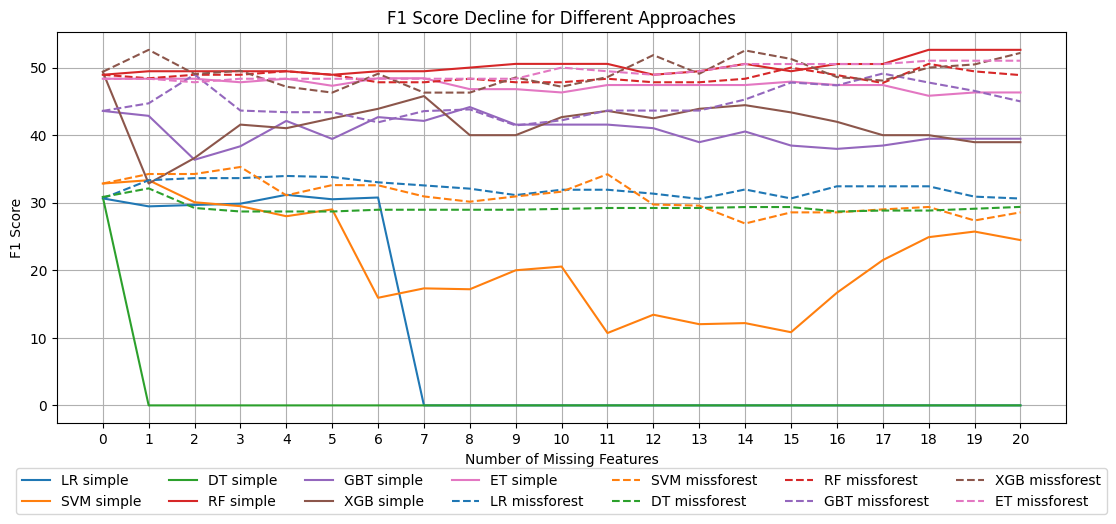

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

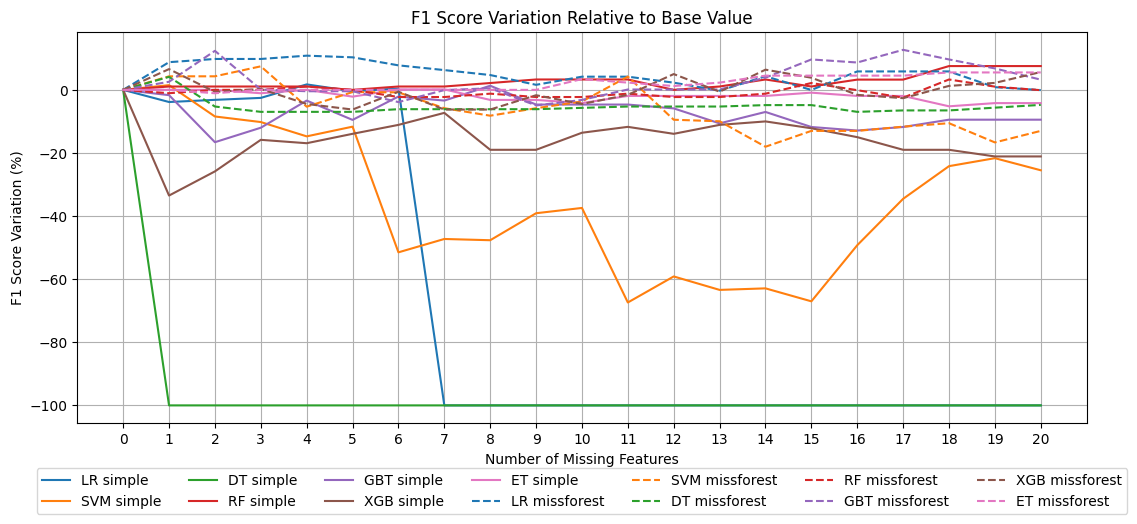

In [ ]:
# # Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced Accuracy**

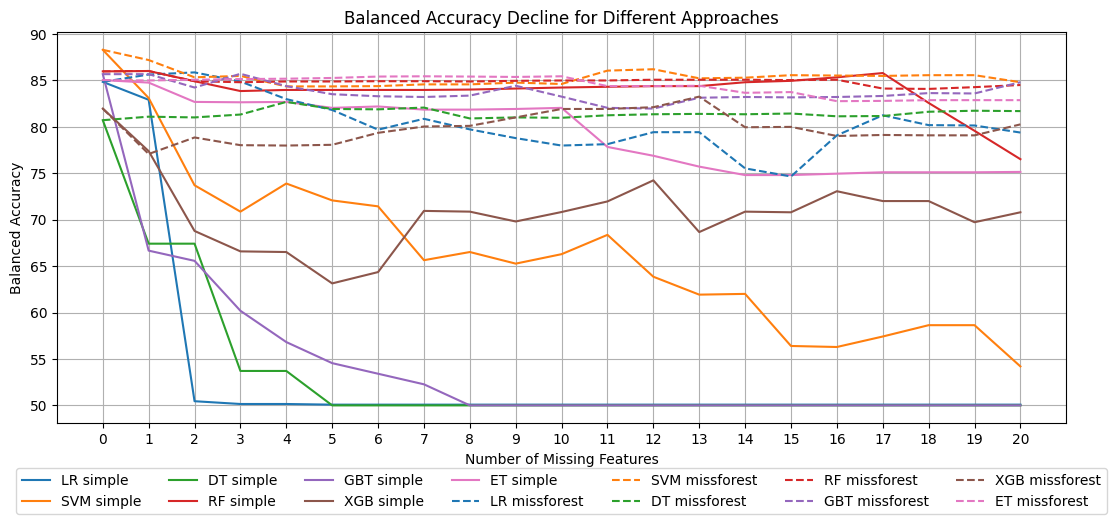

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

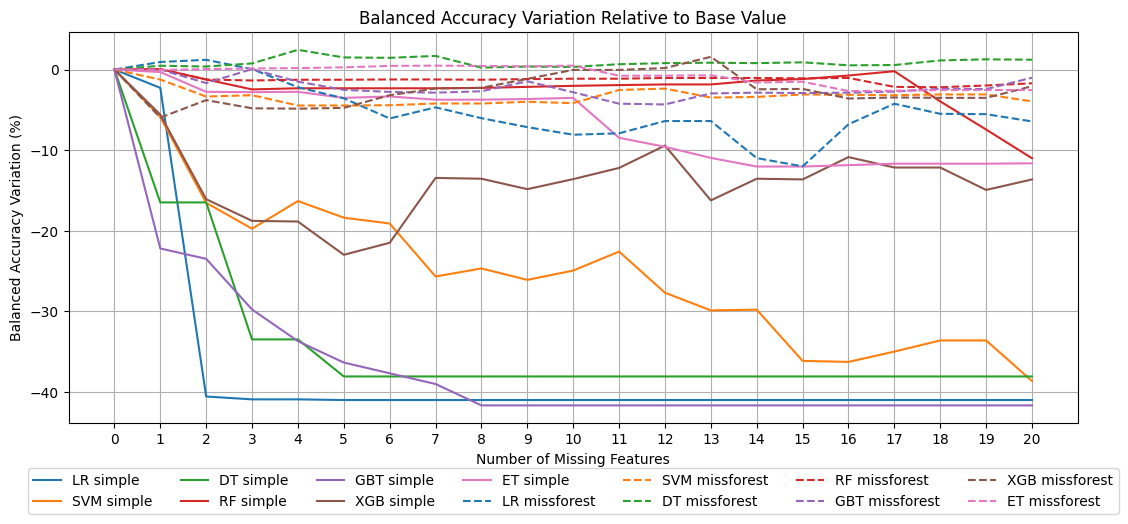

In [ ]:
# # Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf,
}

all_data = combine_datasets(
    dataset_dict,
    'Taiwanese Bankruptcy',  'Scenario 1: standard',
    RANDOM_STATE
)
save_dataset(all_data, 'taiwanese_bankruptcy_scenario1_seed_1981.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0    36  1165  155   8      18.85   81.82        88.26     88.05     30.64   
1    33  1173  147  11      18.33   75.00        88.86     88.42     29.46   
2    31  1186  134  13      18.79   70.45        89.85     89.22     29.67   
3    33  1176  144  11      18.64   75.00        89.09     88.64     29.86   
4    36  1169  151   8      19.25   81.82        88.56     88.34     31.17   
..   ..   ...  ...  ..        ...     ...          ...       ...       ...   
583  33  1195  125  11      20.89   75.00        90.53     90.03     32.67   
584  33  1196  124  11      21.02   75.00        90.61     90.10     32.84   
585  33  1198  122  11      21.29   75.00        90.76     90.25     33.17   
586  33  1198  122  11      21.29   75.00        90.76     90.25     33.17   
587  33  1198  122  11      21.29   75.00        90.76     90.25     33.17   

     balanced_accuracy  num_feat_missing  \
0                85.04                 0   
1                81.93                 1   
2                80.15                 2   
3                82.05                 3   
4                85.19                 4   
..                 ...               ...   
583              82.77                16   
584              82.80                17   
585              82.88                18   
586              82.88                19   
587              82.88                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1                      ['Equity to Liability'] imputed      lr_perf   
2    ['Equity to Liability', 'Cash Flow to Liabilit...      lr_perf   
3    ['Equity to Liability', 'Cash Flow to Liabilit...      lr_perf   
4    ['Equity to Liability', 'Cash Flow to Liabilit...      lr_perf   
..                                                 ...          ...   
583  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  et2_perf_mf   
584  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  et2_perf_mf   
585  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  et2_perf_mf   
586  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  et2_perf_mf   
587  ['Net worth/Assets', 'Debt ratio %', 'Operatin...  et2_perf_mf   

                   source              scenario  random_state  \
0    Taiwanese Bankruptcy  Scenario 1: standard          1981   
1    Taiwanese Bankruptcy  Scenario 1: standard          1981   
2    Taiwanese Bankruptcy  Scenario 1: standard          1981   
3    Taiwanese Bankruptcy  Scenario 1: standard          1981   
4    Taiwanese Bankruptcy  Scenario 1: standard          1981   
..                    ...                   ...           ...   
583  Taiwanese Bankruptcy  Scenario 1: standard          1981   
584  Taiwanese Bankruptcy  Scenario 1: standard          1981   
585  Taiwanese Bankruptcy  Scenario 1: standard          1981   
586  Taiwanese Bankruptcy  Scenario 1: standard          1981   
587  Taiwanese Bankruptcy  Scenario 1: standard          1981   

                metric  
0             f1 score  
1             f1 score  
2             f1 score  
3             f1 score  
4             f1 score  
..                 ...  
583  balanced accuracy  
584  balanced accuracy  
585  balanced accuracy  
586  balanced accuracy  
587  balanced accuracy  

[588 rows x 17 columns]